## Overturning in density space

This is a test notebook for computing overturning in density space using `xgcm` and `xhitogram` libraries. Here, we use monthly data for one hindcast and one ensemble member. We follow the approach of the following example.

https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-Interpolation

In [1]:
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xesmf as xe
import cf_xarray
import gsw as gsw
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, performance_report
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize
from cmip6_preprocessing.regionmask import merged_mask
import regionmask

In [2]:
#client = Client(n_workers=2)

#print(client)

In [3]:
var_list = ['thetao', 'so', 'vo', 'uo']

ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

year, r = (2010, 0) 

ds = []
for var in var_list:
    
    var_path = "s" + str(year) +"-r" + str(r+1) + "i1p1f2/Omon/"+ var +"/gn/files/d20200417/"
    ds1 = xr.open_mfdataset(ppdir + var_path + "*gn_2010*.nc", decode_times=False)
    
    if(var == 'uo'):
        ds1 = ds1.rename({'i':'i_c', 'longitude':'longitude_u', 'latitude':'latitude_u', 'vertices_latitude':'vertices_latitude_u', 
                        'vertices_longitude':'vertices_longitude_u'})
    
    elif(var == 'vo'):
        ds1 = ds1.rename({'j':'j_c', 'longitude':'longitude_v', 'latitude':'latitude_v', 'vertices_latitude':'vertices_latitude_v', 
                        'vertices_longitude':'vertices_longitude_v'})
        
    ds.append(ds1)
    
ds = xr.merge(ds)

In [4]:
# create outer depth levels

level_outer_data = cf_xarray.bounds_to_vertices(ds.lev_bnds, 'bnds').load().data

ds = ds.assign_coords({'level_outer': level_outer_data})

ds = ds.isel(time=1)

print(ds)

<xarray.Dataset>
Dimensions:               (bnds: 2, lev: 75, j: 1205, i: 1440, vertices: 4,
                           j_c: 1205, i_c: 1440, level_outer: 76)
Coordinates: (12/13)
    time                  float64 5.794e+04
  * lev                   (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * j                     (j) int32 0 1 2 3 4 5 ... 1200 1201 1202 1203 1204
  * i                     (i) int32 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
    latitude              (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude             (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...                    ...
    latitude_v            (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v           (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * i_c                   (i_c) int32 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
    latitude_u            (j, i_c) float32 dask.array<chunk

In [5]:
print(ds.thetao)

<xarray.DataArray 'thetao' (lev: 75, j: 1205, i: 1440)>
dask.array<getitem, shape=(75, 1205, 1440), dtype=float32, chunksize=(75, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
    time       float64 5.794e+04
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 ... 1198 1199 1200 1201 1202 1203 1204
  * i          (i) int32 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439
    latitude   (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        mo: This variable is reported using a z* coordinate syste...
    units:          degC
    original_name:  mo: (variable_name: thetao)
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello


### Create grid information

In [6]:
grid = Grid(ds, coords={'Z': {'center': 'lev', 'outer': 'level_outer'},
                        'X': {'center': 'i', 'right': 'i_c'},
                        'Y': {'center': 'j', 'right': 'j_c'}}, periodic=[],)
# 'X': {'center': 'i', 'right': 'i_c'},

grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   lev --> outer
  * outer    level_outer --> center
X Axis (not periodic, boundary=None):
  * center   i --> right
  * right    i_c --> center
Y Axis (not periodic, boundary=None):
  * center   j --> right
  * right    j_c --> center

In [7]:
thickness = grid.diff(ds.level_outer, 'Z')

v_transport =  ds.vo * thickness
v_transport = v_transport.fillna(0.).rename('v_transport')

u_transport = ds.uo * thickness
u_transport = u_transport.fillna(0.).rename('u_transport')

print(v_transport, u_transport)

<xarray.DataArray 'v_transport' (lev: 75, j_c: 1205, i: 1440)>
dask.array<where, shape=(75, 1205, 1440), dtype=float64, chunksize=(75, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
    time         float64 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray> <xarray.DataArray 'u_transport' (lev: 75, j: 1205, i_c: 1440)>
dask.array<where, shape=(75, 1205, 1440), dtype=float64, chunksize=(75, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
    time         float64 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j            (j) int32 0 1 2 3 4 5 6 ... 1198 1199 1200 1201 1202 1203 1204
 

### Tranform from Z to theta

Here, we transform meridional transport data from $z$ to $\theta$ coordinate. We further compare $\psi(z)$ and $\psi(\theta)$. 

In [16]:
ds['theta'] = grid.interp(ds.thetao, ['Y'], boundary='extend')
ds.theta

<xarray.DataArray 'theta' (time: 2, lev: 75, j_c: 1205, i: 1440)>
dask.array<mul, shape=(2, 75, 1205, 1440), dtype=float32, chunksize=(2, 75, 1204, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>

In [17]:
target_theta_levels = np.arange(-2, 36)

v_transport_theta = grid.transform(v_transport, 'Z', target_theta_levels,
                                   target_data=ds.theta, method='conservative')
v_transport_theta

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'v_transport' (time: 2, j_c: 1205, i: 1440, theta: 37)>
dask.array<transpose, shape=(2, 1205, 1440, 37), dtype=float64, chunksize=(2, 1204, 1440, 37), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * theta        (theta) float64 -1.5 -0.5 0.5 1.5 2.5 ... 31.5 32.5 33.5 34.5

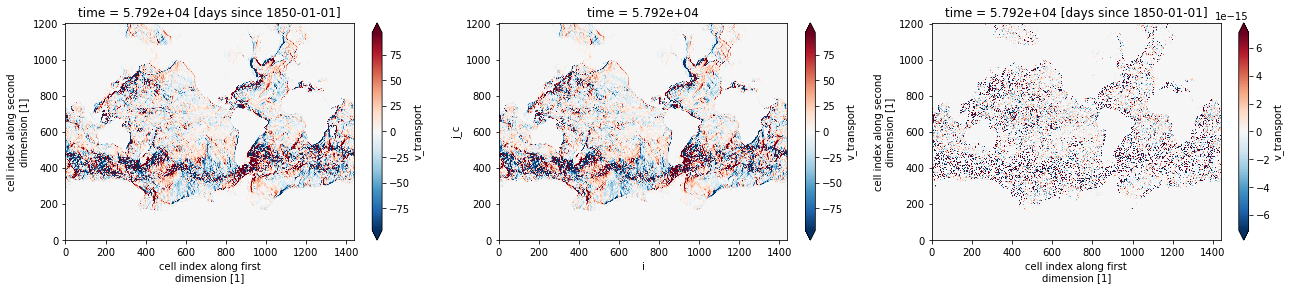

In [20]:
fig = plt.figure(figsize=[22,4])
    
plt.subplot(1,3,1)
tmp_z = v_transport.isel(time=0).sum(dim='lev').compute()
tmp_z.plot(robust=True)
    
plt.subplot(1,3,2)
tmp_theta = v_transport_theta.isel(time=0).sum(dim='theta').compute()
tmp_theta.plot(robust=True)

plt.subplot(1,3,3)
(tmp_z - tmp_theta).plot(robust=True)

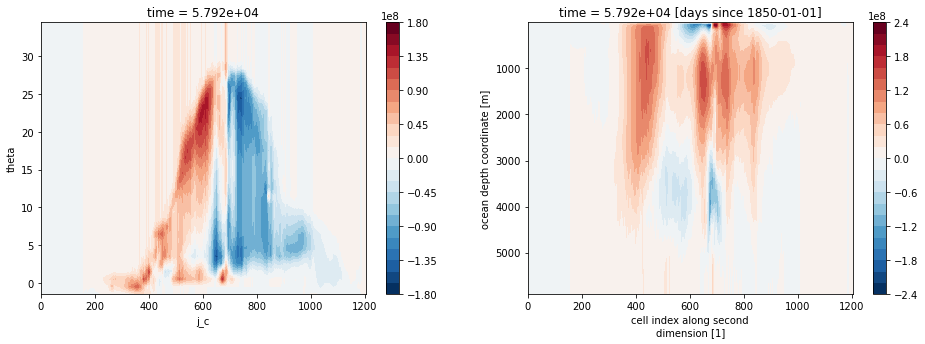

In [25]:
# compute overturning circulation

dx = 110e3 * np.cos(np.deg2rad(ds.latitude_v))

psi_theta = (v_transport_theta.isel(time=0) * dx).sum(dim='i').cumsum(dim='theta').compute()
psi_z = (v_transport.isel(time=0) * dx).sum(dim='i').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
psi_theta.plot.contourf(x='j_c', levels=31)

plt.subplot(1,2,2)
psi_z.plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

## Transform to density coordinates

For comaparison, we use two methods
1. use `xgcm` transform approach to compute transport at specfici density levels and then use `cumsum` to compute overturning at those density levels.
2. Without using `xgcm` transform, Compute transport at density levels smaller than a density levels to compute overturning and repeat this for all density levels.

In [8]:
def pdens(S,theta):

    pot_dens = gsw.density.sigma0(S, theta)

    return pot_dens

sigma = xr.apply_ufunc(pdens, ds.so, ds.thetao, dask='parallelized', output_dtypes=[ds.thetao.dtype])

sigma = sigma.compute()

ds['sigma0_v'] = grid.interp(sigma, ['Y'], boundary='extend').compute()

ds['sigma0_u'] = grid.interp(sigma, ['X'], boundary='extend').compute()


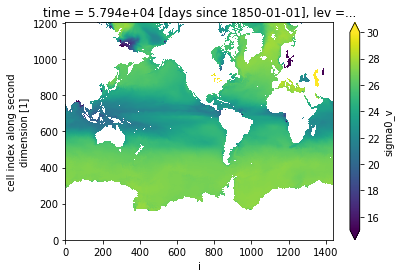

In [9]:
ds.sigma0_v.isel(lev=0).plot(vmin=15., vmax=30.)

In [10]:
target_sigma_levels = np.arange(18., 31., 0.2)

v_transport_sigma = grid.transform(v_transport, 'Z', target_sigma_levels,
                                   target_data=ds.sigma0_v, method='conservative')

u_transport_sigma = grid.transform(u_transport, 'Z', target_sigma_levels,
                                   target_data=ds.sigma0_u, method='conservative')

v_transport_sigma = v_transport_sigma.rename({'sigma0_v':'sigma0'})
u_transport_sigma = u_transport_sigma.rename({'sigma0_u':'sigma0'})

print(v_transport_sigma, u_transport_sigma)

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(


<xarray.DataArray 'v_transport' (j_c: 1205, i: 1440, sigma0: 64)>
dask.array<transpose, shape=(1205, 1440, 64), dtype=float64, chunksize=(1205, 1440, 64), chunktype=numpy.ndarray>
Coordinates:
    time         float64 5.794e+04
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * sigma0       (sigma0) float64 18.1 18.3 18.5 18.7 ... 30.1 30.3 30.5 30.7 <xarray.DataArray 'u_transport' (j: 1205, i_c: 1440, sigma0: 64)>
dask.array<transpose, shape=(1205, 1440, 64), dtype=float64, chunksize=(1205, 1440, 64), chunktype=numpy.ndarray>
Coordinates:
    time         float64 5.794e+04
  * j            (j) int32 0 1 2 3 4 5 6 ... 1198 1199 1200 1201 1202 1203 1204
  * i_c          (i_c) int32 0 1 2 3 4 5 6 ... 1434 1435 

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


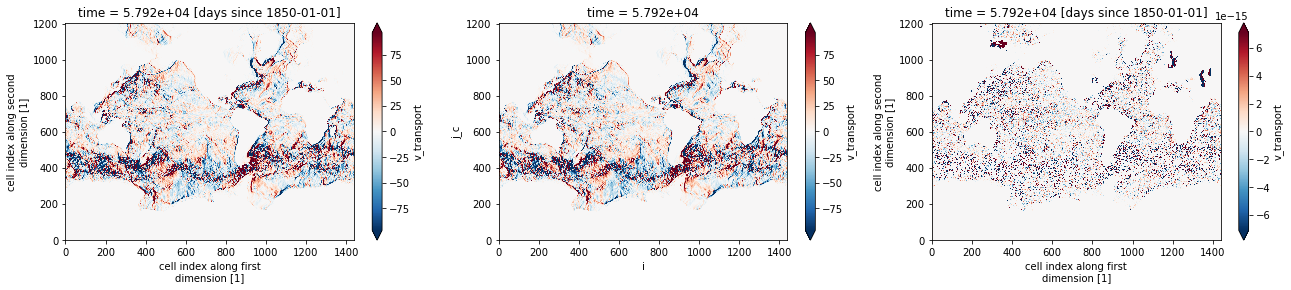

In [14]:
fig = plt.figure(figsize=[22,4])
    
plt.subplot(1,3,1)
tmp_z = v_transport.isel(time=0).sum(dim='lev').compute()
tmp_z.plot(robust=True)
    
plt.subplot(1,3,2)
tmp_sigma = v_transport_sigma.isel(time=0).sum(dim='sigma0').compute()
tmp_sigma.plot(robust=True)

plt.subplot(1,3,3)
(tmp_z - tmp_sigma).plot(robust=True)

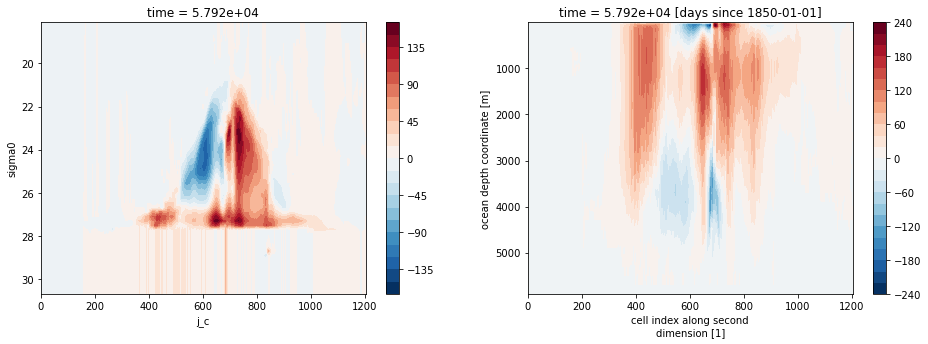

In [14]:
# compute overturning circulation

dx = 110e3 * np.cos(np.deg2rad(ds.latitude_v))

psi_sigma = (v_transport_sigma.isel(time=0) * dx).sum(dim='i').cumsum(dim='sigma0').compute()
psi_z = (v_transport.isel(time=0) * dx).sum(dim='i').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
(psi_sigma/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
(psi_z/1e6 - psi_z.isel(lev=-1)/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

Text(0.5, 0, 'Overturning (Sv)')

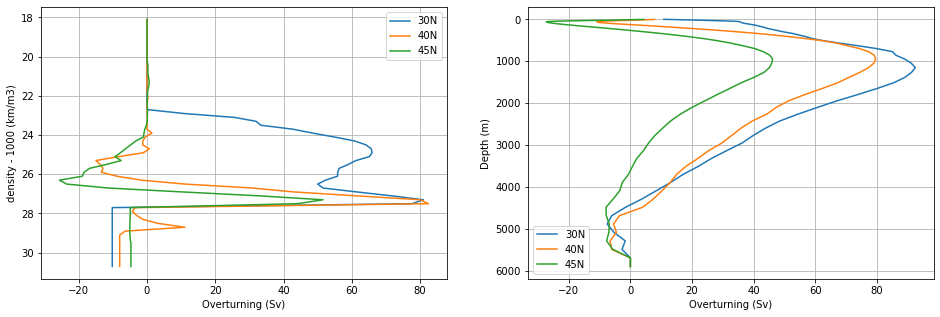

In [20]:
fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
plt.plot(psi_sigma.sel(j_c=809)/1e6, psi_sigma.sigma0, label='30N')
plt.plot(psi_sigma.sel(j_c=860)/1e6, psi_sigma.sigma0, label='40N')
plt.plot(psi_sigma.sel(j_c=890)/1e6, psi_sigma.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('density - 1000 (km/m3)')
plt.xlabel('Overturning (Sv)')
plt.grid('on')

plt.subplot(1,2,2)
plt.plot((psi_z - psi_z.isel(lev=-1)).sel(j_c=809)/1e6, psi_z.lev, label='30N')
plt.plot((psi_z - psi_z.isel(lev=-1)).sel(j_c=860)/1e6, psi_z.lev, label='40N')
plt.plot((psi_z - psi_z.isel(lev=-1)).sel(j_c=890)/1e6, psi_z.lev, label='45N')
plt.gca().invert_yaxis()
plt.legend()
plt.grid('on')
plt.ylabel('Depth (m)')
plt.xlabel('Overturning (Sv)')

In [23]:
print(psi_sigma.sigma0, psi_z.lev)

<xarray.DataArray 'sigma0' (sigma0: 64)>
array([18.1, 18.3, 18.5, 18.7, 18.9, 19.1, 19.3, 19.5, 19.7, 19.9, 20.1, 20.3,
       20.5, 20.7, 20.9, 21.1, 21.3, 21.5, 21.7, 21.9, 22.1, 22.3, 22.5, 22.7,
       22.9, 23.1, 23.3, 23.5, 23.7, 23.9, 24.1, 24.3, 24.5, 24.7, 24.9, 25.1,
       25.3, 25.5, 25.7, 25.9, 26.1, 26.3, 26.5, 26.7, 26.9, 27.1, 27.3, 27.5,
       27.7, 27.9, 28.1, 28.3, 28.5, 28.7, 28.9, 29.1, 29.3, 29.5, 29.7, 29.9,
       30.1, 30.3, 30.5, 30.7])
Coordinates:
    time     float64 5.792e+04
  * sigma0   (sigma0) float64 18.1 18.3 18.5 18.7 18.9 ... 30.1 30.3 30.5 30.7 <xarray.DataArray 'lev' (lev: 75)>
array([5.057600e-01, 1.555855e+00, 2.667682e+00, 3.856280e+00, 5.140361e+00,
       6.543034e+00, 8.092519e+00, 9.822750e+00, 1.177368e+01, 1.399104e+01,
       1.652532e+01, 1.942980e+01, 2.275762e+01, 2.655830e+01, 3.087456e+01,
       3.574020e+01, 4.118002e+01, 4.721189e+01, 5.385064e+01, 6.111284e+01,
       6.902168e+01, 7.761116e+01, 8.692943e+01, 9.704131e+01, 1.0

Let'use the method from MIT_ecco script, which uses both meridional and zonal transports to compute meridional overturning.

In [52]:
ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Global.nc")
print(ds_grid)

<xarray.Dataset>
Dimensions:    (y: 1205, x: 1440, deptht: 75, depthw: 75, xu: 1440, yv: 1205)
Coordinates:
    nav_lat    (y, x) float32 ...
    nav_lon    (y, x) float32 ...
  * deptht     (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * depthw     (depthw) float32 0.0 1.024 2.103 ... 5.393e+03 5.596e+03 5.8e+03
Dimensions without coordinates: y, x, xu, yv
Data variables: (12/15)
    area_t     (y, x) float32 ...
    dz_t       (deptht) float32 ...
    dz_w       (depthw) float32 ...
    area_u     (y, xu) float32 ...
    area_v     (yv, x) float32 ...
    dx_t       (y, x) float32 ...
    ...         ...
    dx_v       (yv, x) float32 ...
    dy_v       (yv, x) float32 ...
    nav_lat_u  (y, xu) float32 ...
    nav_lat_v  (yv, x) float32 ...
    nav_lon_u  (y, xu) float32 ...
    nav_lon_v  (yv, x) float32 ...


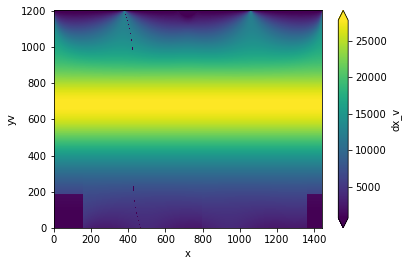

In [54]:
ds_grid.dx_v.plot(robust=True)

In [16]:
RAD_EARTH = 6.387e6

# these are rough dx, dy. Probably give wrong answers
dx = (2 * np.pi * RAD_EARTH/len(ds.i)) * np.cos(np.deg2rad(ds.latitude_v))
dy = (2 * np.pi * RAD_EARTH/len(ds.j))

%time trans_v = (v_transport_sigma * dx).cumsum(dim='sigma0').compute()

%time trans_u = (u_transport_sigma * dy).cumsum(dim='sigma0').compute()

CPU times: user 15.6 s, sys: 4.31 s, total: 19.9 s
Wall time: 19.8 s
CPU times: user 15.8 s, sys: 3.5 s, total: 19.3 s
Wall time: 20.3 s


In [17]:
def get_latitude_masks(lat_val,yc,grid):
    
    """Compute maskW/S which grabs vector field grid cells along specified latitude
    band and corrects the sign associated with X-Y LLC grid
    This mirrors the MATLAB function gcmfaces/gcmfaces_calc/gcmfaces_lines_zonal.m
    Parameters
    ----------
    lat_val : int
        latitude at which to compute mask
    yc : xarray DataArray
        Contains latitude values at cell centers
    grid : xgcm Grid object
        llc grid object generated via get_llc_grid
    Returns
    -------
    maskWedge, maskSedge : xarray DataArray
        contains masks of latitude band at grid cell west and south grid edges
    """

    # Compute difference in X, Y direction.
    # multiply by 1 so that "True" -> 1, 2nd arg to "where" puts False -> 0
    ones = xr.ones_like(yc)
    maskC = ones.where(yc>=lat_val,0)

    maskWedge = grid.diff( maskC, 'X', boundary='fill')
    maskSedge = grid.diff( maskC, 'Y', boundary='fill')

    return maskWedge, maskSedge

In [18]:
%%time

lat_vals = np.arange(-80., 80., 10.)

tmp = np.empty((len(trans_v.sigma0), len(lat_vals)))

trns_lat = xr.Dataset()
trns_lat['trsp_sigma_x'] = xr.DataArray(data=tmp.copy(), coords={'sigma0': trans_v.sigma0,'lat': lat_vals}, 
                                        dims=['sigma0','lat'])
trns_lat['trsp_sigma_y'] = xr.DataArray(data=tmp.copy(), coords={'sigma0': trans_v.sigma0,'lat': lat_vals},
                                        dims=['sigma0','lat'])

for lat in lat_vals:
    
    lat_maskW, lat_maskS = get_latitude_masks(lat, ds.latitude, grid)
    
    lat_trsp_x = (trans_u * lat_maskW).sum(dim=['i_c','j'])
    lat_trsp_y = (trans_v * lat_maskS).sum(dim=['i','j_c'])

    trns_lat['trsp_sigma_x'].loc[{'lat':lat}] = lat_trsp_x
    trns_lat['trsp_sigma_y'].loc[{'lat':lat}] = lat_trsp_y

CPU times: user 1min 30s, sys: 13.6 s, total: 1min 44s
Wall time: 1min 44s


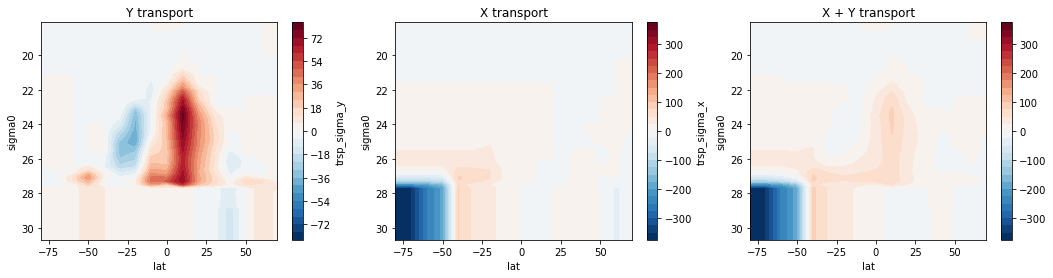

In [19]:
fig = plt.figure(figsize=[18,4])
plt.subplot(1,3,1)
(trns_lat['trsp_sigma_y']/1e6).plot.contourf(x='lat', levels=31)
plt.title('Y transport')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
(trns_lat['trsp_sigma_x']/1e6).plot.contourf(x='lat', levels=31)
plt.title('X transport')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
((trns_lat['trsp_sigma_x'] + trns_lat['trsp_sigma_y'])/1e6).plot.contourf(x='lat', levels=31)
plt.title('X + Y transport')
plt.gca().invert_yaxis()

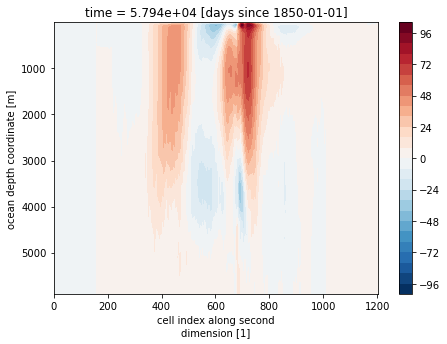

In [15]:
#psi_sigma = trans_v.sum(dim='i').compute()

RAD_EARTH = 6.387e6
dx = (2 * np.pi * RAD_EARTH/len(ds.i)) * np.cos(np.deg2rad(ds.latitude_v))
psi_z = (v_transport * dx).cumsum(dim='lev').sum(dim='i').compute()

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
(psi_z/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

In [13]:
dy = 110e3 * np.cos(np.deg2rad(ds.latitude_u))

len(ds.i)

1440

#### Note

Although the total transport is conserved, at at the largest density levels, there is nonzero overturning. The same is seen for overturning in depth space. Let's use the second method to see if the same issue remains or not.

Based on results below, the answers do not change if binning approach is used instead of `xgcm.transform`. A net nonzero overturing signal is present at largest density levels because there is net nonzero meridional transport in the basin. This nonzero value cane be computed by integraetd the meridional transport diagnostic in `z` and `x`.

In [81]:
def psi_sigma_compute(vo, sigma, sigma_levels):
    
    #psi_bin = []

    #for i in range(0, len(sigma_levels)):

    #tmp = (vo.where(sigma <= sigma_levels))
    
    tmp = (vo.where((sigma <= sigma_levels) & (sigma >= 18.0)))
    
    tmp = tmp.sum(dim=['i','lev'])
    
    return tmp

    #psi_bin.append(tmp)
    
    #psi_bin = xr.concat(psi_bin, dim='sigma0')

In [82]:
dx = 110e3 * np.cos(np.deg2rad(ds.latitude_v))
vo = (v_transport * dx).isel(time=0) 
vo = vo.chunk({'i':100, 'j_c':100})
sigma0 = (ds['sigma0'].isel(time=0)).chunk({'i':100, 'j_c':100})

target_sigma_levels = np.arange(18., 40., 0.2)

psi_sigma_bin = []

for i in range(0, len(target_sigma_levels)):
    
    #v = (vo.where(sigma <= sigma_levels))
    #tmp = xr.apply_ufunc(psi_sigma_compute, vo, sigma0, target_sigma_levels[i], 
    #                     dask='parallelized', output_dtypes=[ds.sigma0.dtype])
    tmp = psi_sigma_compute(vo, sigma0, target_sigma_levels[i])
    psi_sigma_bin.append(tmp)
    
psi_sigma_bin = xr.concat(psi_sigma_bin, dim='sigma0')

In [83]:
%time psi_sigma_bin = psi_sigma_bin.compute() 

CPU times: user 2min 22s, sys: 6.26 s, total: 2min 29s
Wall time: 50.4 s


In [84]:
print(psi_sigma_bin)

<xarray.DataArray (sigma0: 110, j_c: 1205)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.85835220e+02,  9.27605272e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.85835220e+02,  2.51552896e+03,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.40016403e+05,  4.56951111e+05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.40016403e+05,  4.56951111e+05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.40016403e+05,  4.56951111e+05,  0.00000000e+00]])
Coordinates:
    time     float64 5.792e+04
  * j_c      (j_c) int32 0 1 2 3 4 5 6 7 ... 1198 1199 1200 1201 1202 1203 1204
Dimensions without coordinates: sigma0


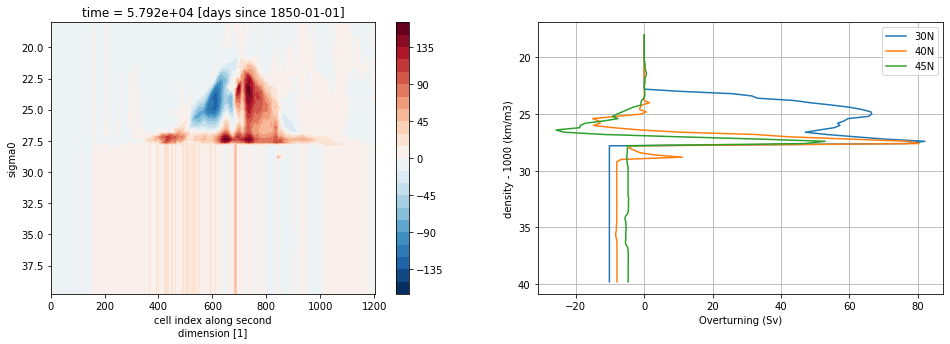

In [80]:
# with tmp = (vo.where(sigma <= sigma_levels)) -> integrate for all density levels smaller than target
psi_sigma_bin = psi_sigma_bin.assign_coords(sigma0 = target_sigma_levels)

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
(psi_sigma_bin/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(psi_sigma_bin.sel(j_c=809)/1e6, psi_sigma_bin.sigma0, label='30N')
plt.plot(psi_sigma_bin.sel(j_c=860)/1e6, psi_sigma_bin.sigma0, label='40N')
plt.plot(psi_sigma_bin.sel(j_c=890)/1e6, psi_sigma_bin.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('density - 1000 (km/m3)')
plt.xlabel('Overturning (Sv)')
plt.grid('on')

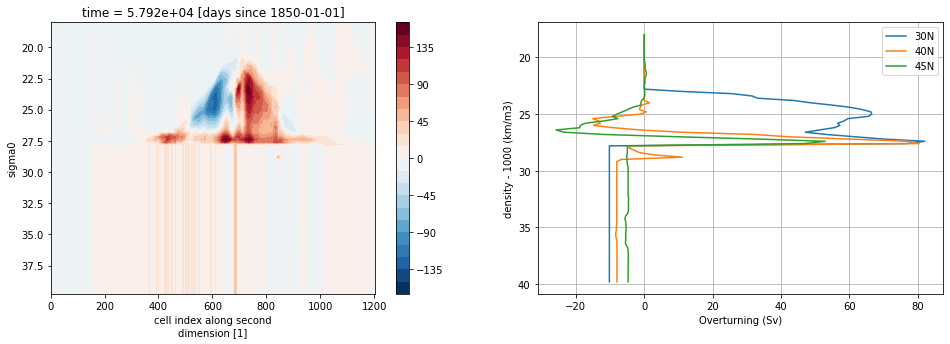

In [85]:
# with tmp = (vo.where((sigma <= sigma_levels) & (sigma >= 18.0))) -> integrate for all density levels smaller than target but greater than 18.
psi_sigma_bin = psi_sigma_bin.assign_coords(sigma0 = target_sigma_levels)

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
(psi_sigma_bin/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(psi_sigma_bin.sel(j_c=809)/1e6, psi_sigma_bin.sigma0, label='30N')
plt.plot(psi_sigma_bin.sel(j_c=860)/1e6, psi_sigma_bin.sigma0, label='40N')
plt.plot(psi_sigma_bin.sel(j_c=890)/1e6, psi_sigma_bin.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('density - 1000 (km/m3)')
plt.xlabel('Overturning (Sv)')
plt.grid('on')

In [86]:
dx = 110e3 * np.cos(np.deg2rad(ds.latitude_v))
%time tmp_z = (v_transport * dx).isel(time=0).sum(dim=['lev', 'i']).compute()

CPU times: user 7.27 s, sys: 2.42 s, total: 9.69 s
Wall time: 9.71 s


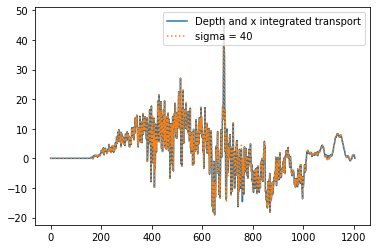

In [91]:
plt.plot(tmp_z/1e6, label='Depth and x integrated transport')
plt.plot(psi_sigma_bin.isel(sigma0=-1)/1e6, label='sigma = 40', ls =':')
plt.legend()

## Only for North Atlantic region

Here, just consider the north atlantic region for computing overturning circulation.

In [5]:
ds_mask = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Mask_Regions.nc")

ds_mask = ds_mask.rename({'j':'j_c'})

print(ds_mask)

ds_grid = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

print(ds_grid)

<xarray.Dataset>
Dimensions:         (j_c: 450, i: 450)
Coordinates:
  * j_c             (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i               (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    nav_lat         (j_c, i) float32 ...
    nav_lon         (j_c, i) float32 ...
Data variables:
    mask_regions    (j_c, i) float64 ...
    mask_North_Atl  (j_c, i) float64 ...
<xarray.Dataset>
Dimensions:    (y: 450, x: 450, deptht: 75, depthw: 75, xu: 450, yv: 450)
Coordinates:
    nav_lat    (y, x) float32 ...
    nav_lon    (y, x) float32 ...
  * deptht     (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * depthw     (depthw) float32 0.0 1.024 2.103 ... 5.393e+03 5.596e+03 5.8e+03
Dimensions without coordinates: y, x, xu, yv
Data variables: (12/15)
    area_t     (y, x) float32 ...
    dz_t       (deptht) float32 ...
    dz_w       (depthw) float32 ...
    area_u     (y, xu) float32 ...
    area_v     (yv, x) float32 ...
    dx_t       (y, 

In [6]:
ds_NA = ds.isel(i=slice(749,1199), j = slice(699, 1149), j_c = slice(699, 1149), i_c=slice(749,1199))
# i_c=slice(749,1199)

ds_NA = xr.merge([ds_NA, ds_mask, ds_grid['dx_v'].rename({'x':'i', 'yv':'j_c'}),
                 ds_grid['dx_u'].rename({'xu':'i_c', 'y':'j'}),
                 ds_grid['dy_u'].rename({'xu':'i_c', 'y':'j'})])

ds_NA

<xarray.Dataset>
Dimensions:               (j: 450, i: 450, j_c: 450, i_c: 450, time: 2,
                           bnds: 2, lev: 75, vertices: 4, level_outer: 76)
Coordinates: (12/15)
  * j                     (j) int64 699 700 701 702 703 ... 1145 1146 1147 1148
  * i                     (i) int64 749 750 751 752 753 ... 1195 1196 1197 1198
  * j_c                   (j_c) int64 699 700 701 702 ... 1145 1146 1147 1148
  * i_c                   (i_c) int64 749 750 751 752 ... 1195 1196 1197 1198
  * time                  (time) float64 5.792e+04 5.794e+04
  * lev                   (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
    ...                    ...
    longitude_v           (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    latitude_u            (j, i_c) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_u           (j, i_c) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * level_outer           (level_outer) float64 0.0 1.024 ... 5.8e+03 6.004e+03
    nav_lat               (j_c, i) float32 ...
    nav_lon               (j_c, i) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables: (12/17)
    time_bnds             (time, bnds) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    lev_bnds              (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    vertices_latitude     (j, i, vertices) float32 dask.array<chunksize=(450, 450, 4), meta=np.ndarray>
    vertices_longitude    (j, i, vertices) float32 dask.array<chunksize=(450, 450, 4), meta=np.ndarray>
    thetao                (time, lev, j, i) float32 dask.array<chunksize=(2, 75, 450, 450), meta=np.ndarray>
    so                    (time, lev, j, i) float32 dask.array<chunksize=(2, 75, 450, 450), meta=np.ndarray>
    ...                    ...
    uo                    (time, lev, j, i_c) float32 dask.array<chunksize=(2, 75, 450, 450), meta=np.ndarray>
    mask_regions          (j_c, i) float64 ...
    mask_North_Atl        (j_c, i) float64 ...
    dx_v                  (j_c, i) float32 ...
    dx_u                  (j, i_c) float32 ...
    dy_u                  (j, i_c) float32 ...
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2021-03-01T08:58:11Z
    ...                     ...
    tracking_id:            hdl:21.14100/0c7c3929-d043-48a8-8b98-24ac6e95c274
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [7]:
grid = Grid(ds_NA, coords={'Z': {'center': 'lev', 'outer': 'level_outer'},
                           'X': {'center': 'i', 'right': 'i_c'},
                           'Y': {'center': 'j', 'right': 'j_c'}}, periodic=[],)
# 'X': {'center': 'i', 'right': 'i_c'},
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   lev --> outer
  * outer    level_outer --> center
X Axis (not periodic, boundary=None):
  * center   i --> right
  * right    i_c --> center
Y Axis (not periodic, boundary=None):
  * center   j --> right
  * right    j_c --> center

In [8]:
thickness = grid.diff(ds_NA.level_outer, 'Z')

v_transport_NA = ds_NA.vo * thickness
v_transport_NA = v_transport_NA.fillna(0.).rename('v_transport_NA')

u_transport_NA = ds_NA.uo * thickness
u_transport_NA = u_transport_NA.fillna(0.).rename('u_transport_NA')

print(v_transport_NA, u_transport_NA)

<xarray.DataArray 'v_transport_NA' (time: 2, lev: 75, j_c: 450, i: 450)>
dask.array<where, shape=(2, 75, 450, 450), dtype=float64, chunksize=(2, 75, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude_v   (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat      (j_c, i) float32 ...
    nav_lon      (j_c, i) float32 ... <xarray.DataArray 'u_transport_NA' (time: 2, lev: 75, j: 450, i_c: 450)>
dask.array<where, shape=(2, 75, 450, 450), dtype=float64, chunksize=(2, 75, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * j            (j) int64 699 700 701 702 703 704 ... 1144 1145 1146 1147 1

In [16]:
def pdens(S,theta):

    pot_dens = gsw.density.sigma0(S, theta)

    return pot_dens

sigma = xr.apply_ufunc(pdens, ds_NA.so, ds_NA.thetao, dask='parallelized', output_dtypes=[ds_NA.thetao.dtype])

%time sigma = sigma.compute()

ds_NA['sigma0'] = sigma

ds_NA['sigma0_v'] = grid.interp(sigma, ['Y'], boundary='extend').compute()

ds_NA['sigma0_u'] = grid.interp(sigma, ['X'], boundary='extend').compute()

CPU times: user 9.29 s, sys: 2.95 s, total: 12.2 s
Wall time: 10.5 s


In [11]:
a = np.arange(15., 20., 2.0)
b = np.arange(20., 23.1, 1.)
c = np.arange(23.2, 26., 0.2)
d = np.arange(26.1, 28., 0.1)
e = np.arange(28.0, 28.8, 0.2)
f = np.arange(29.0, 31.1, 1.)

target_sigma_levels = np.concatenate((a ,b, c, d, e, f))

print(target_sigma_levels)
print(target_sigma_levels.shape)

[15.  17.  19.  20.  21.  22.  23.  23.2 23.4 23.6 23.8 24.  24.2 24.4
 24.6 24.8 25.  25.2 25.4 25.6 25.8 26.  26.1 26.2 26.3 26.4 26.5 26.6
 26.7 26.8 26.9 27.  27.1 27.2 27.3 27.4 27.5 27.6 27.7 27.8 27.9 28.
 28.2 28.4 28.6 28.8 29.  30.  31. ]
(49,)


In [12]:
#target_sigma_levels = np.arange(18., 31., 0.2)

v_transport_NA_sigma = grid.transform(v_transport_NA, 'Z', target_sigma_levels,
                                   target_data=ds_NA.sigma0_v, method='conservative')

u_transport_NA_sigma = grid.transform(u_transport_NA, 'Z', target_sigma_levels,
                                   target_data=ds_NA.sigma0_u, method='conservative')

v_transport_NA_sigma = v_transport_NA_sigma.rename({'sigma0_v':'sigma0'})
u_transport_NA_sigma = u_transport_NA_sigma.rename({'sigma0_u':'sigma0'})

print(v_transport_NA_sigma, u_transport_NA_sigma)

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(


<xarray.DataArray 'v_transport_NA' (time: 2, j_c: 450, i: 450, sigma0: 48)>
dask.array<transpose, shape=(2, 450, 450, 48), dtype=float64, chunksize=(2, 450, 450, 48), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) float64 5.792e+04 5.794e+04
    latitude_v   (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat      (j_c, i) float32 ...
    nav_lon      (j_c, i) float32 ...
  * sigma0       (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.7 28.9 29.5 30.5 <xarray.DataArray 'u_transport_NA' (time: 2, j: 450, i_c: 450, sigma0: 48)>
dask.array<transpose, shape=(2, 450, 450, 48), dtype=float64, chunksize=(2, 450, 450, 48), chunktype=numpy.ndarray>
Coordinates:
  * j            (j) int64 699 700 701 702 703 704 ... 114

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


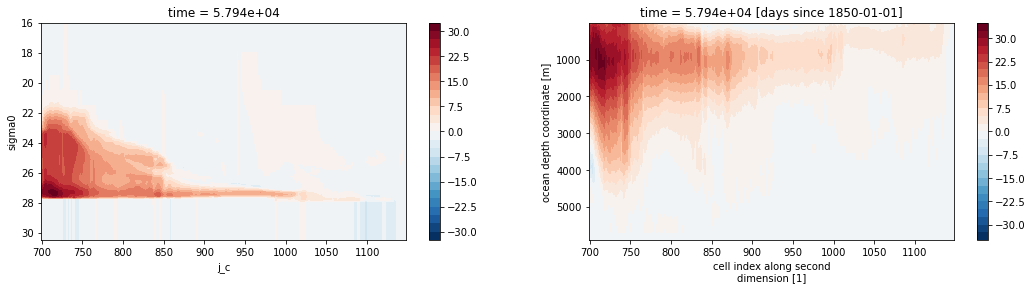

In [13]:
# using v_transport only
dx = ds_NA['dx_v']

psi_sigma_NA = ((v_transport_NA_sigma.isel(time=1) * dx).where(ds_NA.mask_North_Atl==0.)).sum(dim='i').cumsum(dim='sigma0').compute()
psi_z_NA = ((v_transport_NA.isel(time=1) * dx).where(ds_NA.mask_North_Atl==0.)).sum(dim='i').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[18,4])
plt.subplot(1,2,1)
(psi_sigma_NA/1e6 - 0*psi_sigma_NA.isel(sigma0=-1)/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
(psi_z_NA/1e6 - psi_z_NA.isel(lev=-1)/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

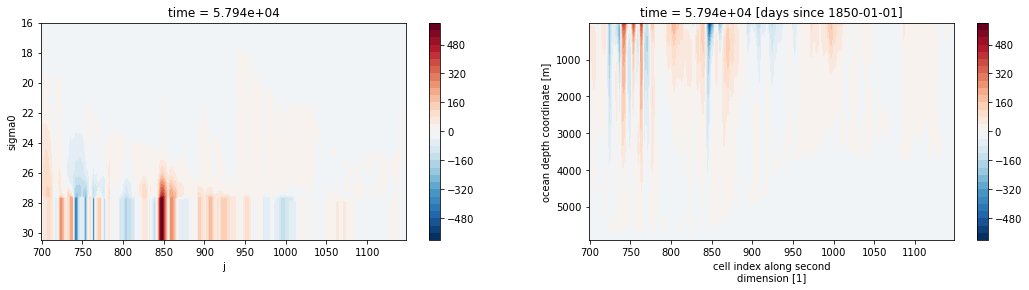

In [24]:
# using u_transport only (gives nonzero large values, cancont integrate along i)

dx = ds_NA['dy_u']
mask = ds_NA.mask_North_Atl.rename({'j_c':'j', 'i':'i_c'})

psi_sigma_NA = ((u_transport_NA_sigma.isel(time=1) * dx).where(mask==0.)).sum(dim='i_c').cumsum(dim='sigma0').compute()
psi_z_NA = ((u_transport_NA.isel(time=1) * dx).where(mask==0.)).sum(dim='i_c').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[18,4])
plt.subplot(1,2,1)
(psi_sigma_NA/1e6 - 0*psi_sigma_NA.isel(sigma0=-1)/1e6).plot.contourf(x='j', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
(psi_z_NA/1e6 - psi_z_NA.isel(lev=-1)/1e6).plot.contourf(x='j', levels=31)
plt.gca().invert_yaxis()

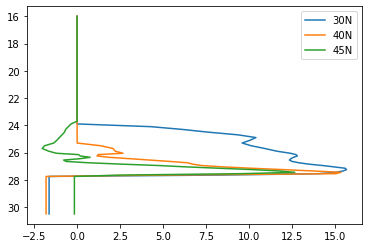

In [143]:
# t=0 (using v_transport only)
plt.plot(psi_sigma_NA.sel(j_c=809)/1e6, psi_sigma_NA.sigma0, label='30N')
plt.plot(psi_sigma_NA.sel(j_c=860)/1e6, psi_sigma_NA.sigma0, label='40N')
plt.plot(psi_sigma_NA.sel(j_c=890)/1e6, psi_sigma_NA.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()

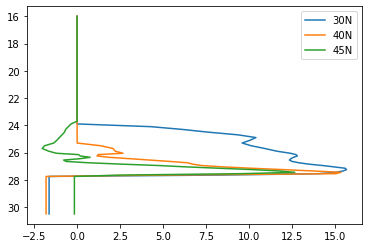

In [144]:
# t=1
plt.plot(psi_sigma_NA.sel(j_c=809)/1e6, psi_sigma_NA.sigma0, label='30N')
plt.plot(psi_sigma_NA.sel(j_c=860)/1e6, psi_sigma_NA.sigma0, label='40N')
plt.plot(psi_sigma_NA.sel(j_c=890)/1e6, psi_sigma_NA.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()

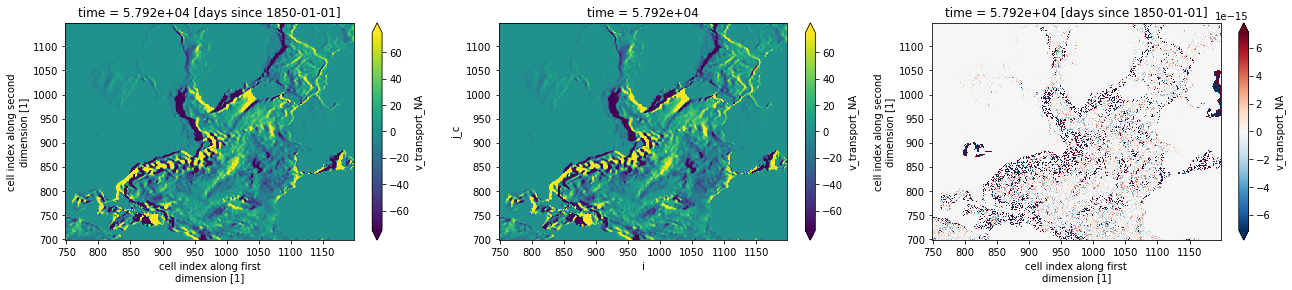

In [145]:
fig = plt.figure(figsize=[22,4])
    
plt.subplot(1,3,1)
tmp_z = v_transport_NA.isel(time=0).sum(dim='lev').compute()
tmp_z.plot(robust=True, vmin=-75., vmax=75.)
    
plt.subplot(1,3,2)
tmp_sigma = v_transport_NA_sigma.isel(time=0).sum(dim='sigma0').compute()
tmp_sigma.plot(robust=True, vmin=-75., vmax=75.)

plt.subplot(1,3,3)
(tmp_z - tmp_sigma).plot(robust=True)

In [19]:
# depth of density levels

#(depth, tmp) = xr.broadcast(v_transport_NA['lev'], v_transport_NA)

depth = xr.ones_like(v_transport_NA) * v_transport_NA['lev']

depth_NA_sigma = grid.transform(depth, 'Z', target_sigma_levels,
                                   target_data=ds_NA['sigma0_v'], method='linear')
print(depth_NA_sigma)

<xarray.DataArray (time: 2, j_c: 450, i: 450, sigma0_v: 49)>
dask.array<transpose, shape=(2, 450, 450, 49), dtype=float64, chunksize=(2, 225, 225, 49), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) float64 5.792e+04 5.794e+04
    latitude_v   (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat      (j_c, i) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.24
    nav_lon      (j_c, i) float32 -99.75 -99.5 -99.25 ... 51.08 51.24 51.41
  * sigma0_v     (sigma0_v) float64 15.0 17.0 19.0 20.0 ... 28.8 29.0 30.0 31.0


/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:146: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


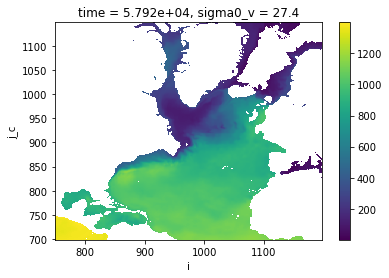

In [21]:
depth_NA_sigma.isel(time=0, sigma0_v=35).plot()

In [167]:
depth_NA_sigma.sigma0.values

array([15. , 17. , 19. , 20. , 21. , 22. , 23. , 23.2, 23.4, 23.6, 23.8,
       24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. ,
       26.1, 26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. , 27.1,
       27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.2, 28.4,
       28.6, 28.8, 29. , 30. , 31. ])

In [187]:
ds_save = xr.Dataset()

#ds_save['v_transport_z'] = v_transport_NA
ds_save['v_transport_sigma'] = v_transport_NA_sigma.astype(np.float32)
ds_save['depth_sigma'] = (depth_NA_sigma.rename({'sigma0':'sigma_bnds'})).astype(np.float32)

ds_save = ds_save.drop(['nav_lat', 'nav_lon','i','j_c'])

ds_save = ds_save.transpose('time','sigma0','sigma_bnds','j_c','i')

print(ds_save)
print("File size in GB = ",ds_save.nbytes/1e9)  

<xarray.Dataset>
Dimensions:            (time: 2, j_c: 450, i: 450, sigma0: 48, sigma_bnds: 49)
Coordinates:
  * time               (time) float64 5.792e+04 5.794e+04
    latitude_v         (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v        (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * sigma0             (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.9 29.5 30.5
  * sigma_bnds         (sigma_bnds) float64 15.0 17.0 19.0 ... 29.0 30.0 31.0
Dimensions without coordinates: j_c, i
Data variables:
    v_transport_sigma  (time, sigma0, j_c, i) float32 dask.array<chunksize=(2, 48, 450, 450), meta=np.ndarray>
    depth_sigma        (time, sigma_bnds, j_c, i) float32 dask.array<chunksize=(2, 49, 225, 225), meta=np.ndarray>
File size in GB =  0.158760792


In [189]:
save_file = "test.nc"
%time delayed_obj = ds_save.to_netcdf(save_file, compute = False)
%time delayed_obj.persist()

CPU times: user 30.6 ms, sys: 56.9 ms, total: 87.5 ms
Wall time: 87.6 ms


/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:146: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


CPU times: user 8.74 s, sys: 1.52 s, total: 10.3 s
Wall time: 7.77 s


Delayed('_finalize_store-28de40a6-d400-476c-b678-813ff696ad83')

In [188]:
save_file = "test.nc"
%time delayed_obj = ds_save.to_netcdf(save_file)

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:146: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


CPU times: user 8.36 s, sys: 1.43 s, total: 9.79 s
Wall time: 7.4 s


In [170]:
print("Size per hindcast per ensemble = ", 125*ds_save.isel(time=0).nbytes/1e9, " GB")

Size per hindcast per ensemble =  10.023848  GB


### Overturning from model native grid

To compute overturning from native grid, one nees to careful as along `i` direction laitude can change. So, integrating in the zonal direction requires pre-checking the location of grid cells. 

For this, we follow the approach from https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_meridional_trsp.py

Baiscally, we run through a loop of lats and only sum tranport that that lie within `lat(i-1)` and `lat(i)`. Also, the algorithm adds both y and x transport values. This is because on grid u, v need to correspond to zonal and meridional directions. Hence, to compute proper meridional transport one should use both `uvel` and `vvel`. Below, we check how this algorithm works for NEMO output. The plots below show that the method works quite nicely.

One could think of regrdding the transport data on lat-lon grid before computing the overturning. However, as shown above, regridding introduces singnificant errors. This is because individual transport values are large and there is a lot of cancellation between these. This cancellation may not be preserved in the regridded data.


In [26]:
dx_v = ds_NA['dx_v']
dy_u = ds_NA['dy_u']
mask_v = ds_NA.mask_North_Atl
mask_u = ds_NA.mask_North_Atl.rename({'j_c':'j', 'i':'i_c'})

%time trans_v = ((v_transport_NA_sigma.isel(time=1) * dx_v).where(mask_v==0.)).cumsum(dim='sigma0').compute()

%time trans_u = ((u_transport_NA_sigma.isel(time=1) * dy_u).where(mask_u==0.)).cumsum(dim='sigma0').compute()

print(trans_v)

CPU times: user 6.82 s, sys: 2.41 s, total: 9.23 s
Wall time: 9.19 s
CPU times: user 9.53 s, sys: 3.14 s, total: 12.7 s
Wall time: 13.8 s
<xarray.DataArray (j_c: 450, i: 450, sigma0: 48)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [

In [32]:
%time trans_v_z = ((v_transport_NA.isel(time=1) * dx_v).where(mask_v==0.)).cumsum(dim='lev').compute()

%time trans_u_z = ((u_transport_NA.isel(time=1) * dy_u).where(mask_u==0.)).cumsum(dim='lev').compute()

CPU times: user 5.18 s, sys: 2.31 s, total: 7.49 s
Wall time: 7.45 s
CPU times: user 5.03 s, sys: 2.18 s, total: 7.21 s
Wall time: 7.11 s


In [28]:
def get_latitude_masks(lat_val,yc,grid):
    
    """Compute maskW/S which grabs vector field grid cells along specified latitude
    band and corrects the sign associated with X-Y LLC grid
    This mirrors the MATLAB function gcmfaces/gcmfaces_calc/gcmfaces_lines_zonal.m
    Parameters
    ----------
    lat_val : int
        latitude at which to compute mask
    yc : xarray DataArray
        Contains latitude values at cell centers
    grid : xgcm Grid object
        llc grid object generated via get_llc_grid
    Returns
    -------
    maskWedge, maskSedge : xarray DataArray
        contains masks of latitude band at grid cell west and south grid edges
    """

    # Compute difference in X, Y direction.
    # multiply by 1 so that "True" -> 1, 2nd arg to "where" puts False -> 0
    ones = xr.ones_like(yc)
    maskC = ones.where(yc>=lat_val,0)

    maskWedge = grid.diff( maskC, 'X', boundary='fill')
    maskSedge = grid.diff( maskC, 'Y', boundary='fill')

    return maskWedge, maskSedge

In [39]:
%%time

lat_vals = np.arange(0., 70., 2.)

tmp = np.empty((len(trans_v.sigma0), len(lat_vals)))
tmp1 = np.empty((len(trans_v_z.lev), len(lat_vals)))

trns_lat = xr.Dataset()
trns_lat['trsp_sigma_x'] = xr.DataArray(data=tmp.copy(), coords={'sigma0': trans_v.sigma0,'lat': lat_vals}, 
                                        dims=['sigma0','lat'])
trns_lat['trsp_sigma_y'] = xr.DataArray(data=tmp.copy(), coords={'sigma0': trans_v.sigma0,'lat': lat_vals},
                                        dims=['sigma0','lat'])
trns_lat['trsp_z_x'] = xr.DataArray(data=tmp1.copy(), coords={'lev': trans_v_z.lev,'lat': lat_vals}, 
                                        dims=['lev','lat'])
trns_lat['trsp_z_y'] = xr.DataArray(data=tmp1.copy(), coords={'sigma0': trans_v_z.lev,'lat': lat_vals},
                                        dims=['lev','lat'])

for lat in lat_vals:
    
    lat_maskW, lat_maskS = get_latitude_masks(lat, ds_NA.latitude, grid)
    
    lat_trsp_x = (trans_u * lat_maskW).sum(dim=['i_c','j'])
    lat_trsp_y = (trans_v * lat_maskS).sum(dim=['i','j_c'])

    trns_lat['trsp_sigma_x'].loc[{'lat':lat}] = lat_trsp_x
    trns_lat['trsp_sigma_y'].loc[{'lat':lat}] = lat_trsp_y
    
    lat_trsp_x = (trans_u_z * lat_maskW).sum(dim=['i_c','j'])
    lat_trsp_y = (trans_v_z * lat_maskS).sum(dim=['i','j_c'])

    trns_lat['trsp_z_x'].loc[{'lat':lat}] = lat_trsp_x
    trns_lat['trsp_z_y'].loc[{'lat':lat}] = lat_trsp_y

CPU times: user 1min, sys: 18.5 s, total: 1min 19s
Wall time: 1min 18s


In [42]:
trns_lat['trsp_z_x'] = trns_lat['trsp_z_x']

In [43]:
print(trns_lat)

<xarray.Dataset>
Dimensions:       (lev: 75, sigma0: 48, lat: 35)
Coordinates:
  * lev           (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * sigma0        (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.7 28.9 29.5 30.5
  * lat           (lat) float64 0.0 2.0 4.0 6.0 8.0 ... 60.0 62.0 64.0 66.0 68.0
Data variables:
    trsp_sigma_x  (sigma0, lat) float64 0.0 0.0 0.0 ... -9.071e+03 1.725e+06
    trsp_sigma_y  (sigma0, lat) float64 0.0 0.0 0.0 ... -1.317e+06 -2.738e+06
    trsp_z_x      (lev, lat) float64 0.0 0.0 0.0 ... -9.071e+03 1.725e+06
    trsp_z_y      (lev, lat) float64 0.0 0.0 5.975e+05 ... -1.317e+06 -2.738e+06


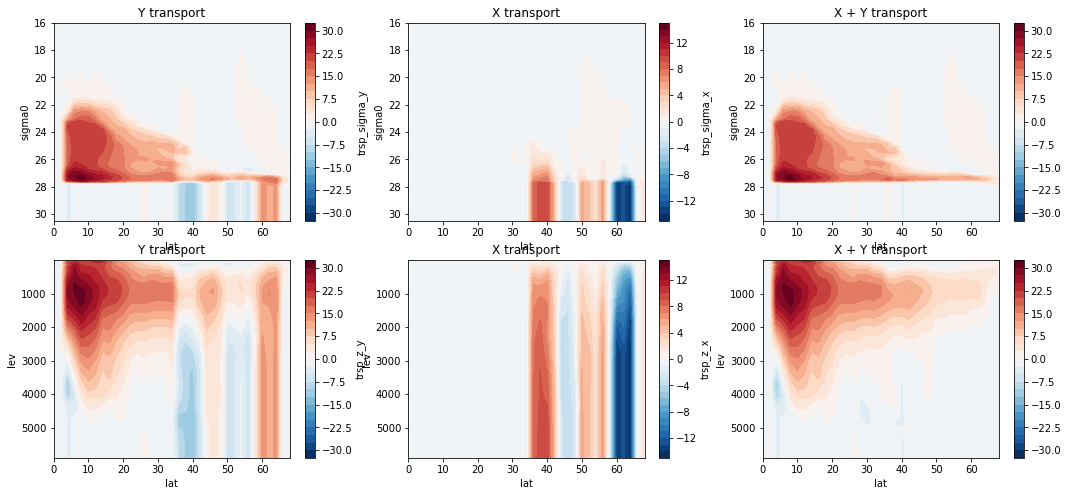

In [44]:
fig = plt.figure(figsize=[18,8])
plt.subplot(2,3,1)
(trns_lat['trsp_sigma_y']/1e6).plot.contourf(x='lat', levels=31)
plt.title('Y transport')
plt.gca().invert_yaxis()

plt.subplot(2,3,2)
(trns_lat['trsp_sigma_x']/1e6).plot.contourf(x='lat', levels=31)
plt.title('X transport')
plt.gca().invert_yaxis()

plt.subplot(2,3,3)
((trns_lat['trsp_sigma_x'] + trns_lat['trsp_sigma_y'])/1e6).plot.contourf(x='lat', levels=31)
plt.title('X + Y transport')
plt.gca().invert_yaxis()

plt.subplot(2,3,4)
(trns_lat['trsp_z_y']/1e6).plot.contourf(x='lat', levels=31)
plt.title('Y transport')
plt.gca().invert_yaxis()

plt.subplot(2,3,5)
(trns_lat['trsp_z_x']/1e6).plot.contourf(x='lat', levels=31)
plt.title('X transport')
plt.gca().invert_yaxis()

plt.subplot(2,3,6)
((trns_lat['trsp_z_x'] + trns_lat['trsp_z_y'])/1e6).plot.contourf(x='lat', levels=31)
plt.title('X + Y transport')
plt.gca().invert_yaxis()

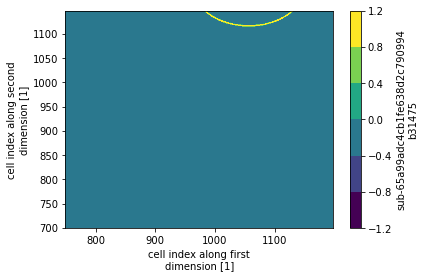

In [82]:
lat_maskW, lat_maskS = get_latitude_masks(80., ds_NA.latitude, grid)

lat_maskS.plot.contourf(cmap="viridis")

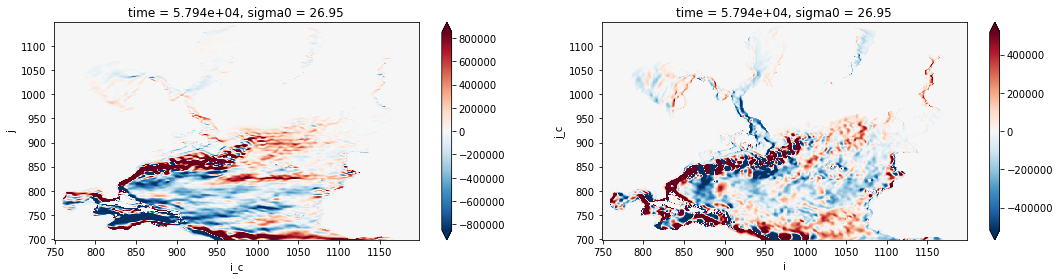

In [89]:
fig = plt.figure(figsize=[18,4])
plt.subplot(1,2,1)
trans_u.isel(sigma0=30).plot(robust=True)

plt.subplot(1,2,2)
trans_v.isel(sigma0=30).plot(robust=True)

## Check saved files

To be sure that computations were done correctly, we plot overturning and sigm depth snapshot.

Further, `xesmf`  library is used to regrid the data to equidistant lat-lon. Firstly, transport can be integrated along fixed lats. Secondly, this reduces data size. 

#### Note - 

For computing overturning, use native grid data to integrate along the zonal direction and just take the mean latitudinal position. Regridding adds large errors and it does not help in improving overturning calculation. Nethertheless, regridding is a good way to reduce datasize. 

In [45]:
ppdir ="/gws/nopw/j04/snapdragon/hkhatri/Data_sigma/Transport_sigma/Temp/"

ds = xr.open_mfdataset(ppdir+"Transport_sigma_1962_r1_*.nc", combine="nested", concat_dim='time')

ds = ds.sortby(ds.time)

In [46]:
ds_mask = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Mask_V_grid.nc")

ds_mask = ds_mask.rename({'j':'j_c'})

ds_grid = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

ds = xr.merge([ds, ds_mask, ds_grid['dx_v'].rename({'x':'i', 'yv':'j_c'})])

ds = ds.drop(['nav_lat', 'nav_lon'])

print(ds)

<xarray.Dataset>
Dimensions:            (time: 125, j_c: 450, i: 450, sigma0: 48, sigma0_bnds: 49)
Coordinates:
  * time               (time) object 1962-11-16 00:00:00 ... 1973-03-16 00:00:00
    latitude_v         (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v        (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * sigma0             (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.9 29.5 30.5
  * sigma0_bnds        (sigma0_bnds) float64 15.0 17.0 19.0 ... 29.0 30.0 31.0
Dimensions without coordinates: j_c, i
Data variables:
    v_transport_sigma  (time, sigma0, j_c, i) float32 dask.array<chunksize=(1, 48, 450, 450), meta=np.ndarray>
    depth_sigma        (time, sigma0_bnds, j_c, i) float32 dask.array<chunksize=(1, 49, 450, 450), meta=np.ndarray>
    mask_North_Atl     (j_c, i) float64 ...
    dx_v               (j_c, i) float32 ...


In [47]:
ds["mask"] = xr.where(ds["mask_North_Atl"]==0., 1, 0)
print(ds)

<xarray.Dataset>
Dimensions:            (time: 125, j_c: 450, i: 450, sigma0: 48, sigma0_bnds: 49)
Coordinates:
  * time               (time) object 1962-11-16 00:00:00 ... 1973-03-16 00:00:00
    latitude_v         (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v        (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * sigma0             (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.9 29.5 30.5
  * sigma0_bnds        (sigma0_bnds) float64 15.0 17.0 19.0 ... 29.0 30.0 31.0
Dimensions without coordinates: j_c, i
Data variables:
    v_transport_sigma  (time, sigma0, j_c, i) float32 dask.array<chunksize=(1, 48, 450, 450), meta=np.ndarray>
    depth_sigma        (time, sigma0_bnds, j_c, i) float32 dask.array<chunksize=(1, 49, 450, 450), meta=np.ndarray>
    mask_North_Atl     (j_c, i) float64 nan nan nan nan nan ... nan nan nan nan
    dx_v               (j_c, i) float32 ...
    mask               (j_c, i) int64 0 0 0 0 0 0 0 0 0 0 ... 0

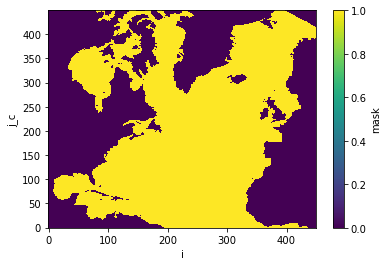

In [48]:
ds.mask.plot()

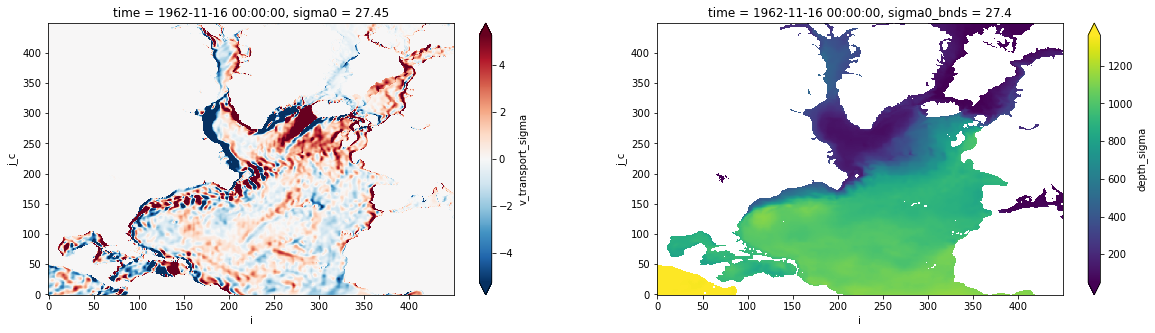

In [49]:
# plot one time snapshot for checking

fig = plt.figure(figsize=[20,5])
    
plt.subplot(1,2,1)
ds['v_transport_sigma'].isel(time=0, sigma0=35).plot(robust=True)

plt.subplot(1,2,2)
ds['depth_sigma'].isel(time=0,sigma0_bnds=35).plot(robust=True)

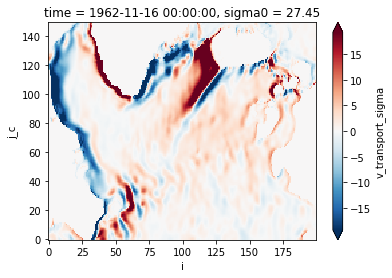

In [50]:
ds.v_transport_sigma.isel(time=0, sigma0=35, i=slice(170, 370), j_c=slice(175, 325)).plot(robust=True)

In [51]:
######## IMPORTANT #################
# this does not work for reigonal basins. Correct the code
######## IMPORTANT #################

def grid_model_sym_approx(ds):
    
    grid_model = xr.Dataset()
    
    grid_model['lat'] = xr.DataArray(ds['lat'].values, dims=['y','x'])
    grid_model['lon'] = xr.DataArray(ds['lon'].values, dims=['y','x'])
    
    ny, nx = grid_model['lon'].shape

    lon_b = np.empty((ny+1, nx+1))
    lat_b = np.empty((ny+1, nx+1))

    lon_b[1:, 1:] = ds['lon'].values
    lat_b[1:, 1:] = ds['lat'].values

    # periodicity
    lon_b[:, 0] = 360 - lon_b[:, -1]
    lat_b[:, 0] = lat_b[:, -1]

    # south edge
    dy = (lat_b[2,:] - lat_b[1,:]).mean()
    lat_b[0, 1:] = lat_b[1,1:] - dy
    lon_b[0, 1:] = lon_b[1, 1:]

    # corner point
    lon_b[0, 0] = lon_b[1,0]
    lat_b[0,0] = lat_b[0,1]

    grid_model['lon_b'] = xr.DataArray(data=lon_b, dims=('yq','xq'))
    grid_model['lat_b'] = xr.DataArray(data=lat_b, dims=('yq','xq'))
    
    return grid_model

In [52]:
# for "conservative" regridding, corner points are required. We read the global grid lats/lons to get the corner points.

path = "/home/users/hkhatri/DePreSys4_Data/Test_Data/ONM_Monthly/"
ds_T = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-T.nc")
ds_U = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-U.nc")

print(ds_T.nav_lat, ds_U.nav_lon)

<xarray.DataArray 'nav_lat' (y: 1207, x: 1442)>
[1740494 values with dtype=float32]
Coordinates:
    nav_lat  (y, x) float32 ...
    nav_lon  (y, x) float32 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    nav_model:      grid_T
    bounds:         bounds_lat <xarray.DataArray 'nav_lon' (y: 1207, x: 1442)>
[1740494 values with dtype=float32]
Coordinates:
    nav_lat  (y, x) float32 ...
    nav_lon  (y, x) float32 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    nav_model:      grid_U
    bounds:         bounds_lon


In [53]:
grid_model = xr.Dataset()

grid_model['lat'] = xr.DataArray(ds['latitude_v'].values, dims=['y','x']) # these are v grid
grid_model['lon'] = xr.DataArray(ds['longitude_v'].values, dims=['y','x']) # these are v grid

grid_model['lat_b'] = xr.DataArray(ds_U['nav_lat'].isel(x=slice(749,1200), y = slice(700, 1151)).values, 
                                   dims=['yq','xq']) # these must be on T grid
grid_model['lon_b'] = xr.DataArray(ds_U['nav_lon'].isel(x=slice(749,1200), y = slice(700, 1151)).values, 
                                   dims=['yq','xq']) # these must be on U grid

print(grid_model)                               

<xarray.Dataset>
Dimensions:  (y: 450, x: 450, yq: 451, xq: 451)
Dimensions without coordinates: y, x, yq, xq
Data variables:
    lat      (y, x) float32 4.121 4.121 4.121 4.121 ... 73.57 73.47 73.36 73.26
    lon      (y, x) float32 -99.75 -99.5 -99.25 -99.0 ... 51.1 51.27 51.43 51.59
    lat_b    (yq, xq) float32 3.997 3.997 3.997 3.997 ... 73.44 73.34 73.23
    lon_b    (yq, xq) float32 -99.88 -99.62 -99.38 -99.12 ... 51.54 51.7 51.86


Text(0.5, 1.0, 'Latitude')

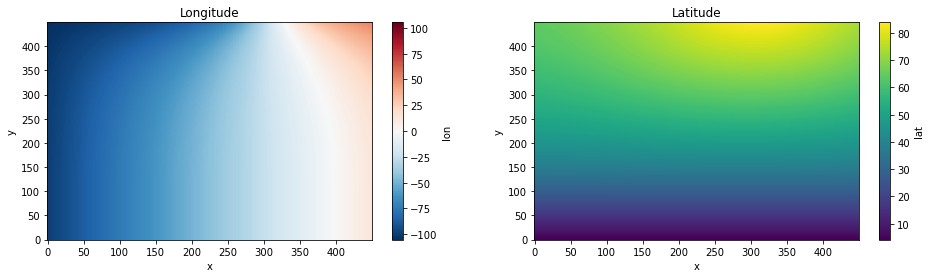

In [54]:
fig = plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
grid_model.lon.plot()
plt.title('Longitude')

plt.subplot(1,2,2)
grid_model.lat.plot()
plt.title('Latitude')

In [67]:
ds_out = xr.Dataset({"lat": (["lat"], np.arange(5., 72., 0.5)),
                     "lon": (["lon"], np.arange(-95., 5., 0.5)),
                    "lat_b": (["lat_b"], np.arange(4.75, 72., 0.5)),
                    "lon_b": (["lon_b"], np.arange(-95.25, 5.25, 0.5)),})

#ds_out = xr.Dataset({"lat": (["lat"], np.arange(5., 76., 0.25)),
#                     "lon": (["lon"], np.arange(-95., 15., 0.25)),
#                    "lat_b": (["lat_b"], np.arange(4.875, 76., 0.25)),
#                    "lon_b": (["lon_b"], np.arange(-95.125, 15., 0.25)),})
print(ds_out)

<xarray.Dataset>
Dimensions:  (lat: 134, lon: 200, lat_b: 135, lon_b: 201)
Coordinates:
  * lat      (lat) float64 5.0 5.5 6.0 6.5 7.0 7.5 ... 69.5 70.0 70.5 71.0 71.5
  * lon      (lon) float64 -95.0 -94.5 -94.0 -93.5 -93.0 ... 2.5 3.0 3.5 4.0 4.5
  * lat_b    (lat_b) float64 4.75 5.25 5.75 6.25 ... 70.25 70.75 71.25 71.75
  * lon_b    (lon_b) float64 -95.25 -94.75 -94.25 -93.75 ... 3.25 3.75 4.25 4.75
Data variables:
    *empty*


In [68]:
tmp = ds.rename({'latitude_v':'lat', 'longitude_v':'lon'}).drop(['mask_North_Atl', 'dx_v'])
regridder = xe.Regridder(tmp, ds_out, "bilinear", extrap_method="nearest_s2d")

#regridder = xe.Regridder(grid_model, ds_out, "conservative_normed") # this is the best scheme -> stick with it

regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_450x450_134x200.nc 
Reuse pre-computed weights? False 
Input grid shape:           (450, 450) 
Output grid shape:          (134, 200) 
Periodic in longitude?      False

In [83]:
fn = regridder.to_netcdf()
print(fn)

conservative_normed_450x450_134x200.nc


In [69]:
tmp = (ds).rename({'latitude_v':'lat', 'longitude_v':'lon'}).drop(['mask_North_Atl', 'dx_v'])

#tmp1 = tmp['v_transport_sigma'].fillna(0.)
#tmp1['depth_sigma'] = tmp['depth_sigma'].fillna(0.)

ds1 = regridder(tmp) #.where((ds.mask_North_Atl==0.) | (ds.mask_regions<=5.) ))

print(ds1)

<xarray.Dataset>
Dimensions:            (time: 125, sigma0: 48, lat: 134, lon: 200,
                        sigma0_bnds: 49)
Coordinates:
  * time               (time) object 1962-11-16 00:00:00 ... 1973-03-16 00:00:00
  * sigma0             (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.9 29.5 30.5
  * sigma0_bnds        (sigma0_bnds) float64 15.0 17.0 19.0 ... 29.0 30.0 31.0
  * lon                (lon) float64 -95.0 -94.5 -94.0 -93.5 ... 3.0 3.5 4.0 4.5
  * lat                (lat) float64 5.0 5.5 6.0 6.5 7.0 ... 70.0 70.5 71.0 71.5
Data variables:
    v_transport_sigma  (time, sigma0, lat, lon) float32 dask.array<chunksize=(1, 48, 134, 200), meta=np.ndarray>
    depth_sigma        (time, sigma0_bnds, lat, lon) float32 dask.array<chunksize=(1, 49, 134, 200), meta=np.ndarray>
    mask               (lat, lon) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    regrid_method:  bilinear


In [59]:
dx = ds['dx_v']
psi = ((ds.v_transport_sigma.where((ds.mask_North_Atl==0.)) * dx)).sum(dim='i').cumsum(dim='sigma0')
lat = ds['latitude_v'].where(ds.mask_North_Atl==0.).mean('i')
psi = psi.assign_coords(j_c = lat)

ds1['psi_sigma'] = psi

print(ds1)

<xarray.Dataset>
Dimensions:            (time: 125, sigma0: 48, lat: 134, lon: 200,
                        sigma0_bnds: 49, j_c: 450)
Coordinates:
  * time               (time) object 1962-11-16 00:00:00 ... 1973-03-16 00:00:00
  * sigma0             (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.9 29.5 30.5
  * sigma0_bnds        (sigma0_bnds) float64 15.0 17.0 19.0 ... 29.0 30.0 31.0
  * lon                (lon) float64 -95.0 -94.5 -94.0 -93.5 ... 3.0 3.5 4.0 4.5
  * lat                (lat) float64 5.0 5.5 6.0 6.5 7.0 ... 70.0 70.5 71.0 71.5
  * j_c                (j_c) float32 4.121 4.371 4.62 ... 74.57 74.17 73.61
Data variables:
    v_transport_sigma  (time, sigma0, lat, lon) float32 dask.array<chunksize=(1, 48, 134, 200), meta=np.ndarray>
    depth_sigma        (time, sigma0_bnds, lat, lon) float32 dask.array<chunksize=(1, 49, 134, 200), meta=np.ndarray>
    mask               (lat, lon) int64 0 0 0 0 0 0 0 0 0 ... 1 0 1 1 1 1 1 1 1
    psi_sigma          (time, sigma0, j_c) float

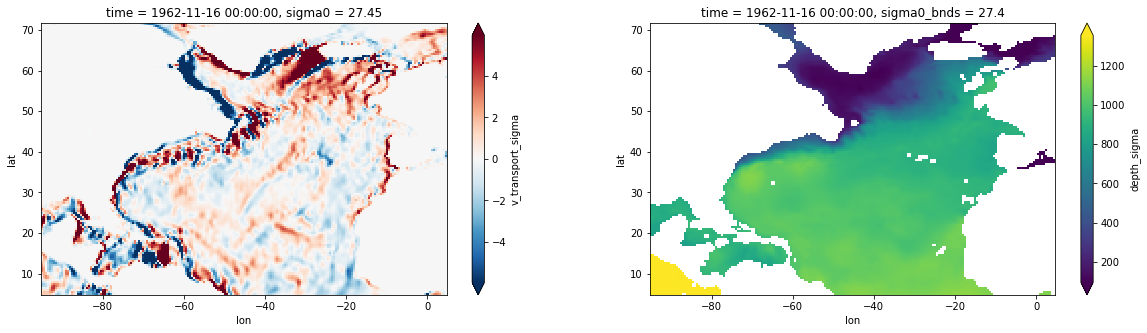

In [60]:
fig = plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
ds1['v_transport_sigma'].isel(time=0, sigma0=35).plot(robust=True)

plt.subplot(1,2,2)
ds1['depth_sigma'].isel(time=0, sigma0_bnds=35).plot(robust=True)

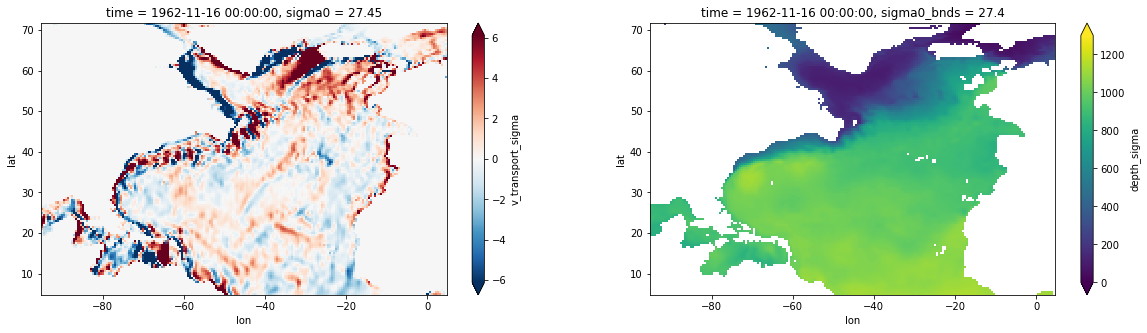

In [70]:
fig = plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
ds1['v_transport_sigma'].isel(time=0, sigma0=35).plot(robust=True)

plt.subplot(1,2,2)
ds1['depth_sigma'].isel(time=0, sigma0_bnds=35).plot(vmin=0., vmax=1300, extend='both')

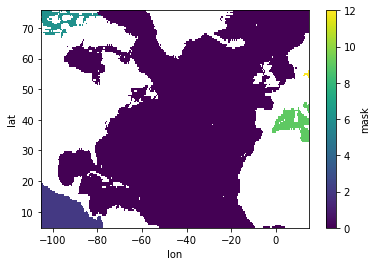

In [156]:
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
mask_regrid = merged_mask(basins, ds_out, lon_name="lon", lat_name="lat")

mask_regrid.plot()

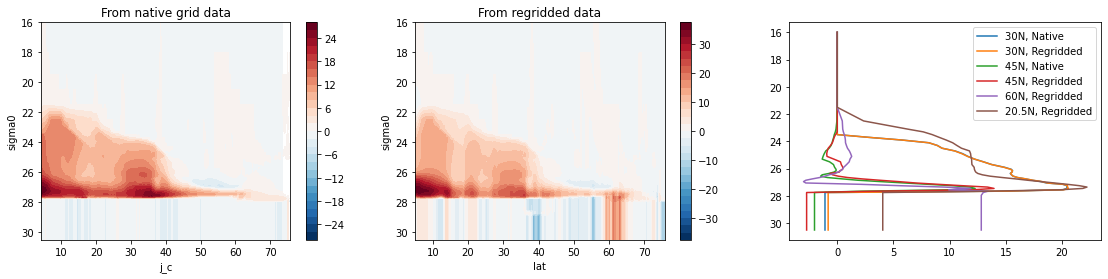

In [31]:
# overturning circulation native grid vs regridded data (bilinear method) 
# Even the added extrapolation option extrap_method="nearest_s2d" gives the same answer)

dx = ds['dx_v']
psi_native = ((ds.v_transport_sigma.isel(time=0).where((ds.mask_North_Atl==0.)) * dx)).sum(dim='i').cumsum(dim='sigma0').compute()

RAD_EARTH = 6.387e6
dx = (np.mean(ds_out['lon'].diff('lon')) * 
                   np.cos(ds_out['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))
psi_regridded = ((ds_out.v_transport_sigma.isel(time=0) * dx)).sum(dim='lon').cumsum(dim='sigma0').compute()

lat = ds['latitude_v'].where(ds.mask_North_Atl==0.).mean('i')
psi_native = psi_native.assign_coords(j_c = lat)

fig = plt.figure(figsize=[19,4])
plt.subplot(1,3,1)
(psi_native/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()
plt.title('From native grid data')

plt.subplot(1,3,2)
(psi_regridded/1e6).plot.contourf(x='lat', levels=31)
plt.gca().invert_yaxis()
plt.title('From regridded data')

plt.subplot(1,3,3)
plt.plot(psi_native.isel(j_c=110)/1e6, psi_native.sigma0, label='30N, Native')
plt.plot(psi_regridded.sel(lat=30.)/1e6, psi_native.sigma0, label='30N, Regridded')
plt.plot(psi_native.isel(j_c=195)/1e6, psi_native.sigma0, label='45N, Native')
plt.plot(psi_regridded.sel(lat=45.)/1e6, psi_native.sigma0, label='45N, Regridded')
plt.plot(psi_regridded.sel(lat=60.)/1e6, psi_native.sigma0, label='60N, Regridded')
plt.plot(psi_regridded.sel(lat=20.5)/1e6, psi_native.sigma0, label='20.5N, Regridded')
plt.gca().invert_yaxis()
plt.legend()

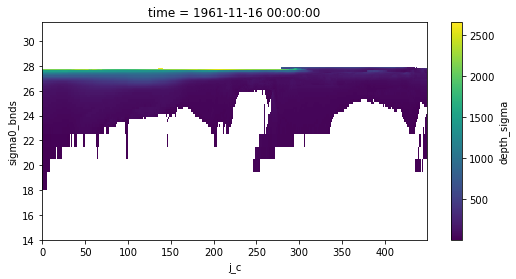

In [30]:
fig = plt.figure(figsize=[19,4])

plt.subplot(1,2,1)
ds['depth_sigma'].where(ds.mask_North_Atl==0.).isel(time=0).mean('i').plot()


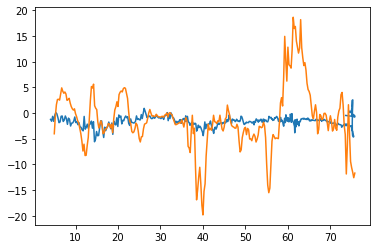

In [32]:
# ignore x-axis. y-axis range is so different. Probably a problem with bilinear method
plt.plot(lat, psi_native.isel(sigma0=-1)/1e6)
plt.plot(psi_regridded.lat, psi_regridded.isel(sigma0=-1)/1e6)

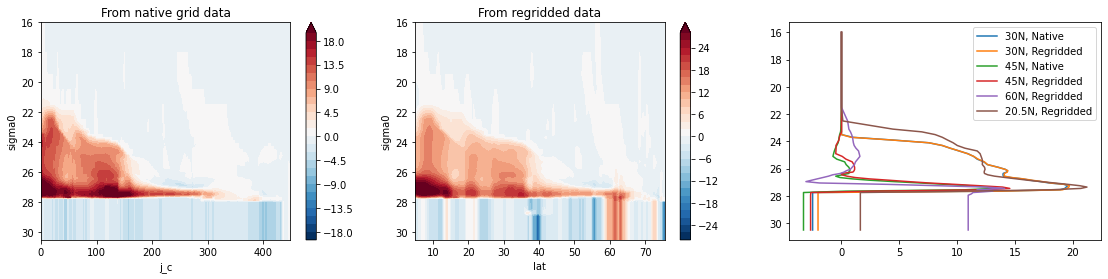

In [141]:
# overturning circulation native grid vs regridded data (conservative_normed method) 
# It does help a bit, but it is not sufficient

dx = ds['dx_v']
psi_native = ((ds.v_transport_sigma.isel(time=0).where((ds.mask_North_Atl==0.) | (ds.mask_regions<=5.)) * dx)).sum(dim='i').cumsum(dim='sigma0').compute()

RAD_EARTH = 6.387e6
dx = (np.mean(ds_out['lon'].diff('lon')) * 
                   np.cos(ds_out['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))
psi_regridded = ((ds_out.v_transport_sigma.isel(time=0) * dx)).sum(dim='lon').cumsum(dim='sigma0').compute()

fig = plt.figure(figsize=[19,4])
plt.subplot(1,3,1)
(psi_native/1e6).plot.contourf(x='j_c', levels=31, robust=True)
plt.gca().invert_yaxis()
plt.title('From native grid data')

plt.subplot(1,3,2)
(psi_regridded/1e6).plot.contourf(x='lat', levels=31, robust=True)
plt.gca().invert_yaxis()
plt.title('From regridded data')

plt.subplot(1,3,3)
plt.plot(psi_native.isel(j_c=110)/1e6, psi_native.sigma0, label='30N, Native')
plt.plot(psi_regridded.sel(lat=30.)/1e6, psi_native.sigma0, label='30N, Regridded')
plt.plot(psi_native.isel(j_c=195)/1e6, psi_native.sigma0, label='45N, Native')
plt.plot(psi_regridded.sel(lat=45.)/1e6, psi_native.sigma0, label='45N, Regridded')
plt.plot(psi_regridded.sel(lat=60.)/1e6, psi_native.sigma0, label='60N, Regridded')
plt.plot(psi_regridded.sel(lat=20.5)/1e6, psi_native.sigma0, label='20.5N, Regridded')
plt.gca().invert_yaxis()
plt.legend()

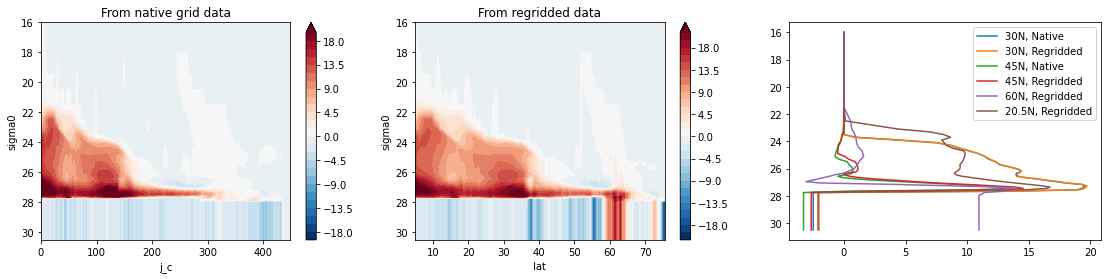

In [158]:
# overturning circulation native grid vs regridded data (conservative_normed method) 
# It does help a bit, but it is not sufficient

dx = ds['dx_v']
psi_native = ((ds.v_transport_sigma.isel(time=0).where((ds.mask_North_Atl==0.)) * dx)).sum(dim='i').cumsum(dim='sigma0').compute()

RAD_EARTH = 6.387e6
dx = (np.mean(ds_out['lon'].diff('lon')) * 
                   np.cos(ds_out['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))
psi_regridded = ((ds_out.v_transport_sigma.isel(time=0) * dx).where(mask_regrid==0.)).sum(dim='lon').cumsum(dim='sigma0').compute()

fig = plt.figure(figsize=[19,4])
plt.subplot(1,3,1)
(psi_native/1e6).plot.contourf(x='j_c', levels=31, robust=True)
plt.gca().invert_yaxis()
plt.title('From native grid data')

plt.subplot(1,3,2)
(psi_regridded/1e6).plot.contourf(x='lat', levels=31, robust=True)
plt.gca().invert_yaxis()
plt.title('From regridded data')

plt.subplot(1,3,3)
plt.plot(psi_native.isel(j_c=110)/1e6, psi_native.sigma0, label='30N, Native')
plt.plot(psi_regridded.sel(lat=30.)/1e6, psi_native.sigma0, label='30N, Regridded')
plt.plot(psi_native.isel(j_c=195)/1e6, psi_native.sigma0, label='45N, Native')
plt.plot(psi_regridded.sel(lat=45.)/1e6, psi_native.sigma0, label='45N, Regridded')
plt.plot(psi_regridded.sel(lat=60.)/1e6, psi_native.sigma0, label='60N, Regridded')
plt.plot(psi_regridded.sel(lat=20.5)/1e6, psi_native.sigma0, label='20.5N, Regridded')
plt.gca().invert_yaxis()
plt.legend()

#### Regrid after cumsum operation

Let's try to regrid after cumsum operation. Hopefully, that would give improve answers.

In [17]:
tmp = (ds['v_transport_sigma'].rename({'latitude_v':'lat', 'longitude_v':'lon'})).cumsum('sigma0')

tmp = tmp.drop(['i', 'j_c','nav_lat','nav_lon']) 

ds_out = regridder(tmp) #.where((ds.mask_North_Atl==0.) | (ds.mask_regions<=5.) ))

print(ds_out)

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('j_c', 'i') from data variable v_transport_sigma as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.DataArray (time: 250, sigma0: 48, lat: 142, lon: 240)>
dask.array<_regrid, shape=(250, 48, 142, 240), dtype=float32, chunksize=(1, 48, 142, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1961-11-16 00:00:00 ... 1972-03-16 00:00:00
  * sigma0   (sigma0) float64 16.0 18.0 19.5 20.5 21.5 ... 28.7 28.9 29.5 30.5
  * lon      (lon) float64 -105.0 -104.5 -104.0 -103.5 ... 13.0 13.5 14.0 14.5
  * lat      (lat) float64 5.0 5.5 6.0 6.5 7.0 7.5 ... 73.5 74.0 74.5 75.0 75.5
Attributes:
    regrid_method:  conservative_normed


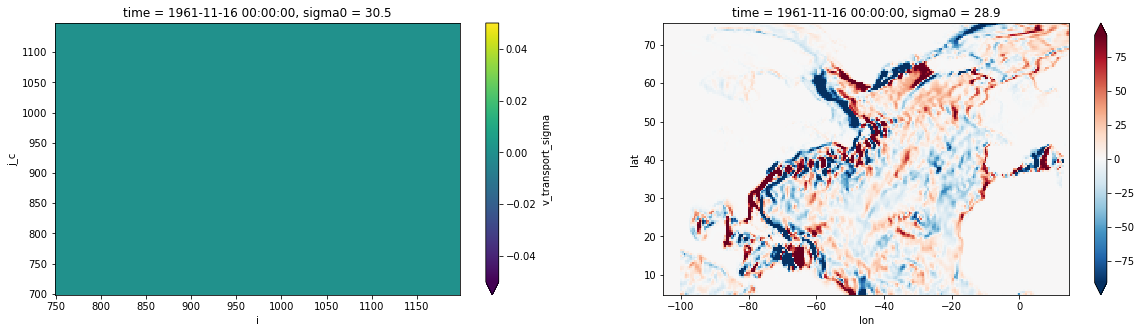

In [27]:
fig = plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
ds['v_transport_sigma'].isel(time=0, sigma0=47).plot(robust=True)

plt.subplot(1,2,2)
ds_out.isel(time=0, sigma0=45).plot(robust=True)

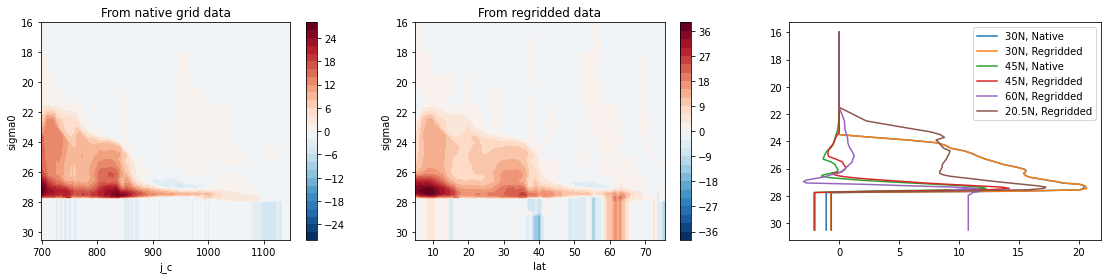

In [20]:
dx = ds['dx_v']
psi_native = ((ds.v_transport_sigma.isel(time=0).where((ds.mask_North_Atl==0.) | (ds.mask_regions<=5.)) * dx)).sum(dim='i').cumsum(dim='sigma0').compute()

RAD_EARTH = 6.387e6
dx = (np.mean(ds_out['lon'].diff('lon')) * 
                   np.cos(ds_out['lat'] * np.pi / 180.) * (2 * np.pi * RAD_EARTH / 360.))
psi_regridded = ((ds_out.isel(time=0) * dx)).sum(dim='lon').compute()

fig = plt.figure(figsize=[19,4])
plt.subplot(1,3,1)
(psi_native/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()
plt.title('From native grid data')

plt.subplot(1,3,2)
(psi_regridded/1e6).plot.contourf(x='lat', levels=31)
plt.gca().invert_yaxis()
plt.title('From regridded data')

plt.subplot(1,3,3)
plt.plot(psi_native.isel(j_c=110)/1e6, psi_native.sigma0, label='30N, Native')
plt.plot(psi_regridded.sel(lat=30.)/1e6, psi_native.sigma0, label='30N, Regridded')
plt.plot(psi_native.isel(j_c=195)/1e6, psi_native.sigma0, label='45N, Native')
plt.plot(psi_regridded.sel(lat=45.)/1e6, psi_native.sigma0, label='45N, Regridded')
plt.plot(psi_regridded.sel(lat=60.)/1e6, psi_native.sigma0, label='60N, Regridded')
plt.plot(psi_regridded.sel(lat=20.5)/1e6, psi_native.sigma0, label='20.5N, Regridded')
plt.gca().invert_yaxis()
plt.legend()

In [63]:
tmp = ds.v_transport_sigma.isel(i=slice(170, 370), j_c=slice(175, 325))

print(tmp)

<xarray.DataArray 'v_transport_sigma' (time: 125, sigma0: 48, j_c: 150, i: 200)>
dask.array<getitem, shape=(125, 48, 150, 200), dtype=float32, chunksize=(1, 48, 150, 200), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1961-11-16 00:00:00 ... 1972-03-16 00:00:00
    latitude_v   (j_c, i) float32 dask.array<chunksize=(150, 200), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(150, 200), meta=np.ndarray>
  * sigma0       (sigma0) float64 16.0 18.0 19.5 20.5 ... 28.7 28.9 29.5 30.5
Dimensions without coordinates: j_c, i


In [64]:
print("Size per file in GB = ", ds_out.nbytes/1e9)
print("Storage for all files in GB = ", 10 * (2017-1960) * ds_out.nbytes/1e9)

print("Size per file in GB = ", tmp.nbytes/1e9)
print("Storage for all files in GB = ", 10 * (2017-1960) * tmp.nbytes/1e9)

Size per file in GB =  1.300126048
Storage for all files in GB =  741.07184736
Size per file in GB =  0.72
Storage for all files in GB =  410.4


## lat-on checks for u,v grids

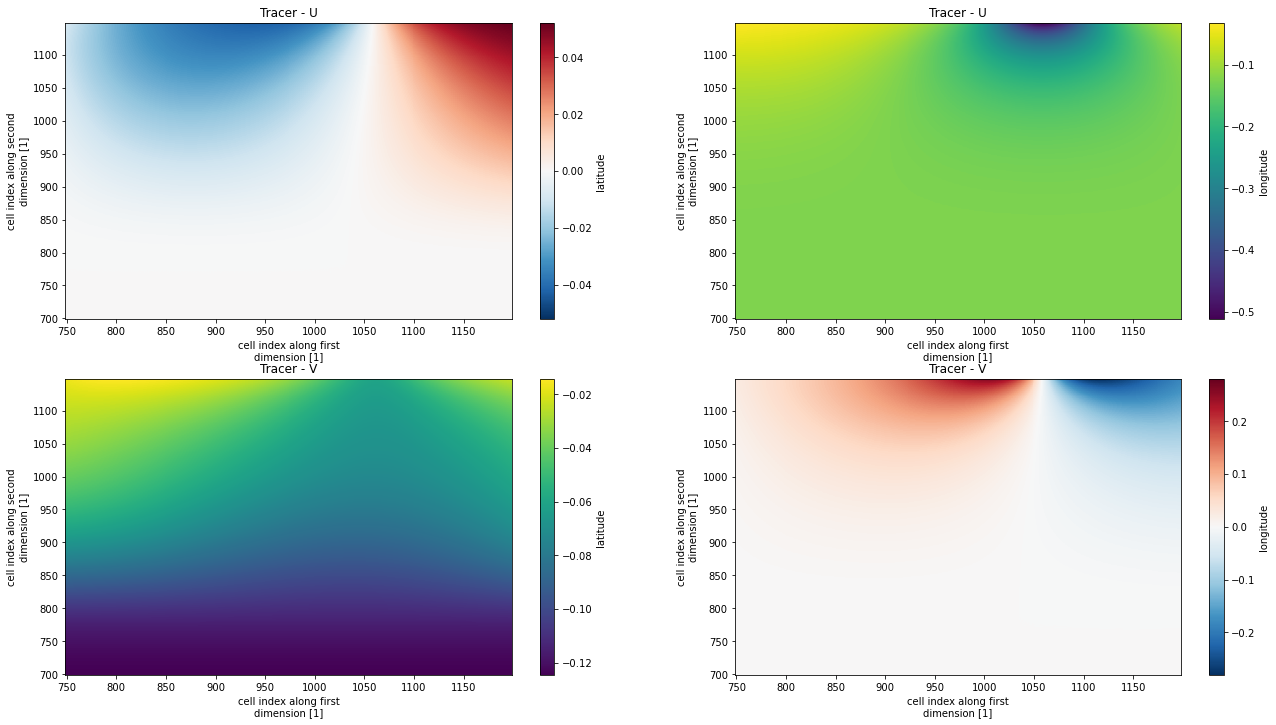

In [4]:

fig = plt.figure(figsize=[22,12])

plt.subplot(2,2,1)
(ds[0].latitude - ds[2].latitude).plot()
plt.title('Tracer - U')

plt.subplot(2,2,2)
(ds[0].longitude - ds[2].longitude).plot()
plt.title('Tracer - U')

plt.subplot(2,2,3)
(ds[0].latitude - ds[3].latitude).plot()
plt.title('Tracer - V');

plt.subplot(2,2,4)
(ds[0].longitude - ds[3].longitude).plot()
plt.title('Tracer - V');

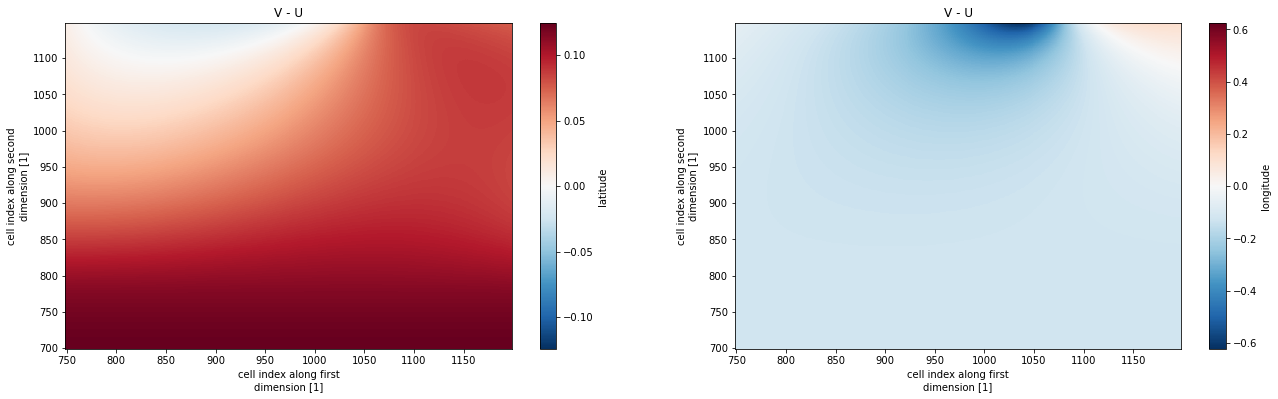

In [6]:
fig = plt.figure(figsize=[22,6])

plt.subplot(1,2,1)
(ds[3].latitude - ds[2].latitude).plot()
plt.title('V - U')

plt.subplot(1,2,2)
(ds[3].longitude - ds[2].longitude).plot()
plt.title('V - U');

Ideally on a C-grid, tracer and V points should be on longitudes. Similarly, tracer and U points should be on same latitudes. There are differences. Let's check this with original data downloaded from Met office archive.

The same issue is present in the test dataset. It seems that grid cells at high-latitudes are arranged in a way that lats/lons do not exactly match.

In [40]:
path = "/home/users/hkhatri/DePreSys4_Data/Test_Data/ONM_Monthly/"
ds_T = xr.open_mfdataset(path + "nemo_av830o_1m_19810301-19810401_grid-T.nc")
ds_U = xr.open_mfdataset(path + "nemo_av830o_1m_19810301-19810401_grid-U.nc")
ds_V = xr.open_mfdataset(path + "nemo_av830o_1m_19810301-19810401_grid-V.nc")

In [41]:
print(ds_T)

<xarray.Dataset>
Dimensions:                (y: 1207, x: 1442, nvertex: 4, deptht: 75,
                            axis_nbounds: 2, deptht300: 35, time_counter: 1)
Coordinates:
    nav_lat                (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    nav_lon                (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
  * deptht                 (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * deptht300              (deptht300) float32 0.5058 1.556 ... 271.4 300.9
    time_centered          (time_counter) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter           (time_counter) float64 0.0
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/74)
    bounds_lon             (y, x, nvertex) float32 dask.array<chunksize=(1207, 1442, 4), meta=np.ndarray>
    bounds_lat             (y, x, nvertex) float32 dask.array<chunksize=(1207, 1442, 4), meta=np.ndarray>
    area                   (y, x) f

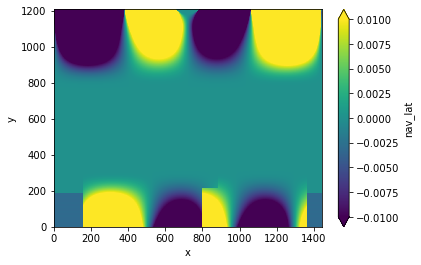

In [14]:
(ds_T.nav_lat - ds_U.nav_lat).plot(vmin=-1e-2, vmax=1e-2)

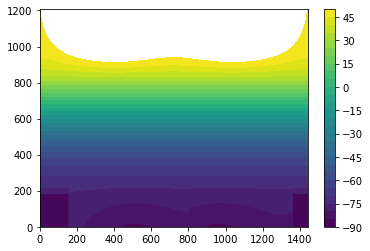

In [49]:
plt.contourf(ds_T.nav_lat.where(ds_T.nav_lat<50.), 30)
plt.colorbar()

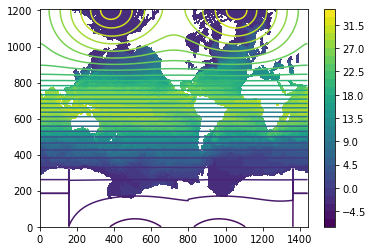

In [59]:
plt.contourf(ds_T.tos.isel(time_counter=0), 30)
plt.colorbar()
plt.contour(ds_T.nav_lat, 30)